In [7]:
!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision.transforms import ToTensor 
import os
from torch import optim
from torch.optim import lr_scheduler
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
import time

import random

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"available {device} device ")

device = torch.device(device)

     |████████████████████████████████| 6.3 MB 7.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=f0ad3c23eeb5f58987c4028bccd6796bcb5fba58a6a5e4e5c656a3a4a33d5259
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
available cuda device 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = "/content/drive/MyDrive/Stocks/Models"
name ="lstm_nov_11_4g (1).pth"
name2 ="cdd1_td1_nov_TATAMOTORS.pth"

In [3]:
plt.rcParams["figure.figsize"] = (40,16)


NameError: ignored

In [ ]:
def ticker_model_name(ticker,model= "cdd1_td1_nov_"):
  return f"{model}{ticker}.pth"


In [4]:
from torch.utils.data import Dataset

def load_latest_model(model, name="model.pt", path='/content'):
    """
    Helper function for Load model
    :param model: current model
    :param name: model name
    :return: loaded model default model.pt
    """
    if path:
      name = os.path.join(path,name)
    model.load_state_dict(torch.load(name))
    return model

def train(model, train_loader, test_loader,
          epochs, optimizer, criterion, scheduler=None,
          name="model.pth", path=None,verbose=True):
    """
    Helper function for train model
    :param model: current model
    :param train_loader: train data loader
    :param test_loader: test data loader
    :param epochs: number of epoch
    :param optimizer: optimizer
    :param criterion: loss function
    :param scheduler: scheduler, default None
    :param name: model name, default model.pt
    :param path: model saved location, default None
    :return: model, list of train loss and test loss
    """

    # compare overfitted
    train_loss_data, valid_loss_data = [], []
    # check for validation loss
    valid_loss_min = np.Inf
    # calculate time
    since = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        if verbose:
          print("Epoch: {}/{}".format(epoch + 1, epochs))
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        total = 0
        
        e_since = time.time()

        ###################
        # train the model #
        ###################
        model.train()  # prep model for training

        for targets, labels in train_loader:
            # Move input and label tensors to the default device
            targets ,labels = targets.float(), labels.float()
            targets, labels = targets.to(device), labels.to(device)
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            ps = model(targets)
            # calculate the loss
            
            loss = criterion(ps, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * targets.size(0)

        ######################
        # validate the model #
        ######################
        if verbose:
           print("\t\tGoing for validation")
        model.eval()  # prep model for evaluation
        for data, target in test_loader:
            # Move input and label tensors to the default device
            data, target = data.float(), target.float()
            data, target = data.to(device), target.to(device)
            #target=target.view(-1,1)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss_p = criterion(output, target)
            # update running validation loss
            valid_loss += loss_p.item() * data.size(0)
            # calculate accuracy
            

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(test_loader.dataset)

        # calculate train loss and running loss
        train_loss_data.append(train_loss * 100)
        valid_loss_data.append(valid_loss * 100)

        if verbose:
          print("\tTrain loss:{:.6f}..".format(train_loss),
              "\tValid Loss:{:.6f}..".format(valid_loss))
            #  "\tAccuracy: {:.4f}".format(1/train_loss)

        if scheduler is not None:
            scheduler.step()  # step up scheduler

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            if verbose:
              print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), name)
            valid_loss_min = valid_loss
            # save to google drive
            if path is not None:
                new=os.path.join(path,name)
                torch.save(model.state_dict(), new)

        # Time take for one epoch
        time_elapsed = time.time() - e_since
        if verbose:
           print('\tEpoch:{} completed in {:.0f}m {:.0f}s'.format(
            epoch + 1, time_elapsed // 60, time_elapsed % 60))

    # compare total time
    time_elapsed = time.time() - since
    if verbose:
      print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model
  
    model = load_latest_model(model, name, path)

    
    # return the model
    return [model, train_loss_data, valid_loss_data]


class CustomTimeSeries(Dataset):
    def __init__(self, x,y):
        x = np.reshape(x, (x.shape[0],x.shape[1],x.shape[2]))
        self.features = x.astype(np.float32)
        self.labels = y.astype(np.float32)
  

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.features[idx,:,:]
        y = self.labels[idx]
        return x, y


def eval(model, test_loader, loss_fn):
#Evaluate testloss 
   losses = []
   model.eval()
   
   for input , target in test_loader:
      input = input.float()
      if torch.cuda.is_available():
        input= input.cuda()
      pred = model(input)
      loss = loss_fn(pred,target)
      losses.append(loss.cpu().detach().numpy())
   #print(f"Losses {loss_fn}: {losses}")
   mean = sum(losses)/len(losses)
   print(f"\nMean loss: {mean}")
   return 






In [15]:
import torch.nn.functional as F
from torch.autograd import Variable
class tradeloss(nn.Module):
  def __init__(self):
    super().__init__()
    self.device = "cuda:0" if torch.cuda.is_available() else 'cpu'
  def __str__(self):
    return 'tradeloss_1'
  def forward(self,pred,target):
    pred,target = pred.squeeze(),target.squeeze()
    y_true_next = target[:,1:]
    y_pred_next = pred[:,1:]
    y_true_tdy = target[:,:-1]
    y_pred_tdy = pred[:,:-1]


    y_true_diff = y_true_next - y_true_tdy
    y_pred_diff = y_pred_next - y_pred_tdy

    standard = torch.zeros_like(y_pred_diff)
    y_true_move = torch.gt(y_true_diff,standard)
    y_pred_move = torch.gt(y_pred_diff,standard)

    condition = torch.ne(y_true_move,y_pred_move)

    alpha =1000*torch.ones_like(y_pred_tdy,dtype=torch.float32,device=self.device)
    ones = torch.ones_like(y_pred_tdy,dtype=torch.float32,device=self.device)
    indexes = torch.where(y_true_move != y_pred_move,alpha,ones)
    ones = torch.ones((pred.shape[0],1),dtype=torch.float32, device=self.device)
    indexes = torch.cat([indexes,ones],dim=1)
    indexes = indexes.to(self.device)
    diff = torch.absolute(pred - target) * indexes
    y = torch.tensor([[i+1 for i in range(diff.shape[1])]], dtype = torch.float32, device=self.device, requires_grad=True) # peanlize more on earlier time predictions
    y = y.broadcast_to((diff.shape[0],diff.shape[1]))     #broadcast
    
    diff = diff*y                   #multiply with diff
    
    loss = torch.mean(diff, 1)
    
    loss_overall = torch.mean(loss)
    
    return loss_overall

class tradeloss_2(nn.Module):
  def __init__(self):
    super().__init__()
    self.device = "cuda:0" if torch.cuda.is_available() else 'cpu'
    self.penalty = 0
  def __str__(self):
    return 'tradeloss_2'
  def forward(self,pred,target):
    pred,target = pred.squeeze(),target.squeeze()
    y_true_next = target[:,1:]
    y_pred_next = pred[:,1:]
    y_true_tdy = target[:,:-1]
    y_pred_tdy = pred[:,:-1]


    y_true_diff = y_true_next - y_true_tdy
    y_pred_diff = y_pred_next - y_pred_tdy

    standard = torch.zeros_like(y_pred_diff)
    y_true_move = torch.gt(y_true_diff,standard)
    y_pred_move = torch.gt(y_pred_diff,standard)

    condition = torch.ne(y_true_move,y_pred_move)

    alpha =1000*torch.ones_like(y_pred_tdy,dtype=torch.float32,device=self.device)
    ones = torch.ones_like(y_pred_tdy,dtype=torch.float32,device=self.device)
    indexes = torch.where(y_true_move != y_pred_move,alpha,ones)
    ones = torch.ones((pred.shape[0],1),dtype=torch.float32, device=self.device)
    indexes = torch.cat([indexes,ones],dim=1)
    indexes = indexes.to(self.device)
    diff = torch.absolute(pred - target) * indexes
    y = torch.tensor([[i+self.penalty for i in range(diff.shape[1],0,-1)]], dtype = torch.float32, device=self.device, requires_grad=True) # peanlize more on earlier time predictions
    y = y.broadcast_to((diff.shape[0],diff.shape[1]))     #broadcast
    
    diff = diff*y                   #multiply with diff
    
    loss = torch.mean(diff, 1)
    
    loss_overall = torch.mean(loss)
    
    return loss_overall


In [16]:
def plot_data(model,data,random_range,row=10,col=8,days=7,randomized=False):
  preds = np.empty([0,10])
  targets = np.empty([0,10])
  figure, axis = plt.subplots(row ,col)
  model.eval()
  
  for input , target in data:
    input = input.float()
    if torch.cuda.is_available():
      input= input.cuda()
    pred = model(input)
    
    pred = pred.cpu().detach().numpy().squeeze()
    target = target.cpu().detach().numpy().squeeze()
    preds = np.concatenate([pred,preds],axis=0)
    targets = np.concatenate([target,targets],axis=0)
  

  if randomized:
    random = np.random.randint(0,random_range,row*col)
    
  else:  
    random = [i for i in range(random_range,random_range+row*col)]
 
  #pred = pred[random:random+4]
  #target = target[random:random+4]
  k=0
  for i in range(row):
    for j in range(col):
       
       axis[i,j].plot(preds[random[k],:days])
       axis[i,j].plot(targets[random[k],:days])
       
       plt.title(f'{k}')
       k=k+1
       


  return 


def plot_models(model,data):
  for i in model:
    plot_data(i,data)

In [ ]:
def plot_charts(model,data,random_range,row=10,col=8,days=7,clip = 3,randomized=False):
  preds = np.empty([0,110])
  targets = np.empty([0,110])
  figure, axis = plt.subplots(row ,col)
  model.eval()
  
  for input , target in data:
    input = input.float()
    target = target.squeeze()
    if torch.cuda.is_available():
      input= input.cuda()
    pred = model(input)
    prev = input[:,:,-1]
    pred = torch.cat((prev,pred),dim=1)
    target = torch.cat((prev,target),dim=1)
    
    pred = pred.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    
    
    

    preds = np.concatenate([pred,preds],axis=0)
    targets = np.concatenate([target,targets],axis=0)
  print(preds.shape)

  if randomized:
    random = np.random.randint(0,random_range,row*col)
    
  else:  
    random = [i for i in range(random_range,random_range+row*col)]
 
  #pred = pred[random:random+4]
  #target = target[random:random+4]
  k=0
  for i in range(row):
    for j in range(col):
       
       axis[i,j].plot(preds[random[k],days:-clip])
       axis[i,j].plot(targets[random[k],days:-clip])
       plt.title(f'{k}')
       
       k=k+1
  return

In [ ]:
def chart_todays(ticker,model,days_cutoff = 3000,days_leave=3,pred_period=10):
  data = StockData(ticker,min_max=True)
  df = data.data
  min_max_y = data.min_max_y
  min_max_data = data.min_max_data
  inputs= df[-100:].to_numpy()
  targets = inputs[:,-1]
  
  inputs = min_max_data.transform(inputs)
  targets = min_max_y.transform([targets])
  targets = targets.squeeze()
  inputs = torch.tensor(inputs, dtype=torch.float32)
  batch=mod.batch
  inputs = inputs.unsqueeze(0).broadcast_to((batch,inputs.shape[0],inputs.shape[1]))
  
  outputs = mod(inputs)
  
  tar1 = torch.tensor(targets,dtype=torch.float32 )
  outputs = outputs[-1,:]
  const = torch.repeat_interleave(tar1[-1],(outputs.shape[0]))
  
  preds = torch.cat((tar1,outputs[:-days_leave])).cpu().detach().numpy()
  targets = torch.cat((tar1,const[:-days_leave])).cpu().detach().numpy()
  preds = min_max_y.inverse_transform([preds]).reshape(-1)
  targets = min_max_y.inverse_transform([targets]).reshape(-1)
  plt.plot(preds)
  plt.plot(targets)
  plt.title(f"Ticker : {ticker}, Pred Period: {pred_period-days_leave}",fontsize=22)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=20)
  return

In [ ]:
def n_model_chart_todays(ticker,models,t_model_names,path,days_cutoff = 3000,days_leave=3,pred_period=10):
  
  data = StockData(ticker,min_max=True)
  df = data.data
  df2 = df[-100:]
  print(f"Date: ")
  min_max_y = data.min_max_y
  min_max_data = data.min_max_data
  inputs= df[-100:].to_numpy()
  
  targets = inputs[:,-1]
  
  inputs = min_max_data.transform(inputs)
  targets = min_max_y.transform([targets])
  targets = targets.squeeze()
  inputs = torch.tensor(inputs, dtype=torch.float32)
  batch=models.batch
  inputs = inputs.unsqueeze(0).broadcast_to((batch,inputs.shape[0],inputs.shape[1]))
  
  
  
  tar1 = torch.tensor(targets,dtype=torch.float32 )
  const = torch.repeat_interleave(tar1[-1],(torch.tensor([pred_period],dtype=torch.int32)))
  targets = torch.cat((tar1,const[:-days_leave])).cpu().detach().numpy()
  targets = min_max_y.inverse_transform([targets]).reshape(-1)
  print(targets.shape)
  for i in range(len(t_model_names)):
    nme = ticker_model_name(t_model_names[i])
    load_latest_model(models,nme,path)
    eval(models,test_loader=test_dataloader,loss_fn=loss_fn)
  
    output = models(inputs)
    output = output[-1,:]
    

    pds = torch.cat((tar1,output[:-days_leave])).cpu().detach().numpy()
    pds = min_max_y.inverse_transform([pds]).reshape(-1)
    
    plt.plot(pds,label=f"Model_on_{t_model_names[i]}")
    
  plt.plot(targets,label = "target")
  plt.legend()  
  plt.title(f"Ticker : {ticker}, Pred Period: {pred_period-days_leave}",fontsize=22)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=20)
  plt.grid()
  plt.show()
  return

In [ ]:
data= StockData("TRIVENI",min_max=False)

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')


In [ ]:
df = data.data
df.tail()

,Adj Close,Volume,d_cma,dd_cma,Adj Close MA
Date,,,,,
2021-11-01,192.869080,468644.0,234.360020,-6.400808,198.474747
2021-11-02,202.808212,988812.0,229.715957,-10.090714,198.352992
2021-11-03,199.925858,592128.0,224.525240,-13.522201,198.422566
2021-11-04,202.162170,237791.0,220.062565,-14.297456,198.862373
2021-11-08,204.149994,626097.0,217.542992,-12.172964,199.518357


In [ ]:
yf.download("TRIVENI.NS")

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-12-13,28.891199,37.110485,28.671286,35.653553,30.868689,69641411.0
2005-12-14,37.385376,38.704861,35.653553,36.890572,31.939684,24896632.0
2005-12-15,37.110485,37.495335,35.186237,36.285805,31.416086,10544835.0
2005-12-16,36.285805,37.110485,34.663940,35.268703,30.535480,5086494.0
2005-12-19,35.736019,38.210052,35.461128,37.522823,32.487083,11410756.0
...,...,...,...,...,...,...
2021-11-02,196.000000,206.500000,194.550003,204.050003,202.808212,988812.0
2021-11-03,205.300003,207.699997,198.500000,201.149994,199.925858,592128.0
2021-11-04,203.800003,206.300003,201.250000,203.399994,202.162170,237791.0


In [12]:
class StockData():
  def __init__(self,ticker,min_max=False):
    
    self.data = None
    self.min_max_y =None
    self.min_max_data = None
    self.ticker = ticker
    self.download(ticker)
    self.features()
    self.data.dropna(inplace=True)
    self.dataframe_out()
    print(self.data.columns)
    self.new_dataset()
    self._pre_minmax()
    return 
  
  def dataframe_out(self, columns = ['Adj Close','Volume','d_cma','dd_cma','Adj Close MA']):
    self.data = self.data[columns]
    return 

  def features(self,roll_ma=20,roll_dma=10,shift_dma=3,scle=10):
    self.data['Adj Close MA'] = self.data['Adj Close'].rolling(roll_ma).mean()
    
    self.data['d_close'] = 10*(self.data['Adj Close MA']- self.data['Adj Close MA'].shift(shift_dma)).rolling(roll_dma).mean()
    
    self.data['d_cma'] = self.data['Adj Close MA'] + self.data['d_close']
    
    self.data['dd_cma'] = self.data['d_cma']- self.data['d_cma'].shift(shift_dma)
    
    return
  
  @staticmethod
  def train_test_val_split(X,Y,split = 0.1, val = True,shuffle=True):
    x1,x2,y1,y2 = train_test_split(X, Y, test_size=0.1, shuffle=False)
    if val:
      x1,x3,y1,y3 = train_test_split(x1, y1, test_size=0.1, shuffle=shuffle)
      return x1,x3,x2,y1,y3,y2
    else:
      return x1,x2,y1,y2

  def download(self,ticker,Id=".NS"):
    if self.data == None:
      if type(ticker) == str:
        ticker = ticker + Id
        self.data = yf.download(ticker)
 

  def new_dataset(self, step_size=100, pred_period=10):
    dataset = self.data.to_numpy()
    data_X, data_Y = [], []
    for i in range(dataset.shape[0]-step_size-pred_period-1):
# here is the inclusion of features for the model
        a = dataset[i:(i+step_size)]
        data_X.append(a)
        data_Y.append(dataset[i+step_size :(i+step_size + pred_period), -1])
    self.X,self.Y=  np.array(data_X), np.array(data_Y)
    return
  
  def _pre_minmax(self):
    self.min_max_data = MinMaxScaler()
    self.min_max_y = MinMaxScaler()
    self.min_max_data.fit(self.data.to_numpy()[:])
    self.min_max_y.fit(self.data.to_numpy()[:,-1].reshape(-1,1))
    return 

  def min_max(self):
    scaled_X = []
    scaled_Y = []
    for i in range(len(self.X)):
      x = self.min_max_data.transform(self.X[i])
      
      y = self.min_max_y.transform(self.Y[i].reshape(-1,1))
      
      scaled_X.append(x)
      scaled_Y.append(y)
      
    
    self.X_scaled, self.Y_scaled = np.array(scaled_X), np.array(scaled_Y)
    #print(self.Y_scaled.shape)
    return self.X_scaled, self.Y_scaled




#prepare everything

def prepare(tickers,min_max=False,batch=32,shuffle=False,id=".NS"):
  X ,Y = [],[]
  k=1
  for ticker in tickers:
    data = StockData(ticker=ticker,min_max=min_max)
    x,y = data.min_max()
    if k==1:
      X = x
      Y = y
    else:
      X = np.concatenate([X,x],0)
      Y = np.concatenate([Y,y], 0)
    k=k+1
  print(X.shape)
  x_train,x_val,x_test,y_train,y_val, y_test = data.train_test_val_split(X,Y,shuffle=shuffle)
  x_train= x_train[len(x_train)%batch:]
  y_train = y_train[len(y_train)%batch:] 
  x_val = x_val[len(x_val)%batch:]
  y_val = y_val[len(y_val)%batch:]
  x_test = x_test[len(x_test)%batch:]
  y_test = y_test[len(y_test)%batch:]
  print(f"len x_train {x_train.shape}, y_train {len(y_train)}; x_val{x_val.shape}; y val {len(y_val)} ; x test {x_test.shape} y test {len(y_test)}")
  traindata = CustomTimeSeries(x_train,y_train)
  train_dataloader = DataLoader(traindata, batch_size=batch, shuffle=False)
  valdata = CustomTimeSeries(x_val,y_val)
  val_dataloader = DataLoader(valdata, batch_size=batch, shuffle=False)
  testdata = CustomTimeSeries(x_test,y_test)

  test_dataloader = DataLoader(testdata, batch_size=batch, shuffle=False)
  return train_dataloader, val_dataloader, test_dataloader

In [ ]:
class AdditiveAttention(nn.Module):

  def __init__(self, y1 =128,y2=512,period=10, dropout=0.5,batch=32, **kwargs):
    super(AdditiveAttention, self).__init__()
    self.period = period
    self.W_enc = nn.Linear( y1+y2, y1, bias=False)
    
    
    
    self.act = nn.Tanh()
    
    
    self.dropout = nn.Dropout(dropout)
  def forward(self,y1,y2):
    y3 , y4 = y1.squeeze(),y2.squeeze()
    y = torch.cat([y3,y4],dim=-1)
    y = self.act(self.W_enc(y))
    y = nn.functional.softmax(y,dim=-1 )
    y = y.unsqueeze(1)
    yp = y.permute(0,2,1).broadcast_to((y1.shape[0],y1.shape[1],y1.shape[1]))
    
    weights = torch.bmm(yp,y1)
    
    
   
    return weights

class CNND(nn.Module):
  def __init__(self,batch,pred_period=10,lookout_days =100,  input_features=5,teacher_enforce=0.5):
    super().__init__()
    self.batch = batch
    self.period = pred_period 
    self.enc_seq_len = lookout_days
    self.input_size = input_features
   
    
    self.device = ("cuda" if torch.cuda.is_available() else "cpu")
    self.teacher_enforce = teacher_enforce
    
    self.attention = AdditiveAttention()
    self.conv1 = nn.Conv1d(in_channels = 5, out_channels= 32 ,kernel_size=3,stride=2)
    self.pool12= nn.MaxPool1d(kernel_size=3)
    self.pool13= nn.MaxPool1d(kernel_size=2)
    self.conv12 = nn.Conv1d(in_channels = 32, out_channels= 64 ,kernel_size=3,stride=2)
    self.conv123 = nn.Conv1d(in_channels = 64, out_channels= 128 ,kernel_size=3)

    self.conv2 = nn.Conv1d(in_channels = 100, out_channels= 256 ,kernel_size=2)
    self.conv21 = nn.Conv1d(in_channels = 256, out_channels= 512 ,kernel_size=2)
    self.pool23 = nn.MaxPool1d(kernel_size=3)

    self.convT1 = nn.ConvTranspose1d(128,64,kernel_size=5)
    self.convT2 = nn.ConvTranspose1d(64,64,kernel_size=3)
    self.convT3 = nn.ConvTranspose1d(64,32,kernel_size=2)
    self.convT4 = nn.ConvTranspose1d(32,1,kernel_size=3)

    #New line
    self.act1 = nn.Sigmoid()
    self.act2 = nn.ReLU()
    #self.dense2 = nn.Linear(in_features=self.hidden_size, out_features=1,bias=False)
    
  def forward(self,inp):
    x = inp
    x1 = inp.permute(0,2,1)
    y1 = self.conv1(x1)
    y1 = self.pool12(y1)
    y1= self.conv12(y1)
    y1 = self.pool13(y1)
    y1 = self.conv123(y1)
    y2 = self.conv2(x)
    y2 = self.conv21(y2)
    y2 = self.pool23(y2)
    
    
    y1 = self.attention(y1,y2)

    

    z = self.convT1(y1)
    z = self.convT2(z)
    z = self.convT3(z)
    z = self.convT4(z)
   
   
    return z.squeeze(1)

mod = CNND(32)

#theoratical best 3.6 on trade loss

In [ ]:
#identity block
class identity_block(nn.Module):
  def __init__(self,param):
    super().__init__()
    self.param = param
    self.act = nn.ReLU()
    self.bm = nn.BatchNorm1d(num_features= (self.param[0]))
    self.cv1 = nn.Conv1d(in_channels=param[0],out_channels=self.param[1],kernel_size=1)
    self.cv12 = nn.Conv1d(in_channels=self.param[1],out_channels=self.param[1],kernel_size=3,padding=1)
    self.drop = nn.Dropout(0.4)
    self.connection= nn.Sequential(self.act,self.bm,self.cv1,self.drop,self.cv12)
    
  def forward(self,x,y):   #x:X y:shortcut
    y1 = self.connection(x)
    
    y1 =self.act(y1+y)
    return y1,y

#transform Block
class transform_block(nn.Module):
  def __init__(self,param):
    super().__init__()
    self.param = param
    self.act = nn.ReLU()
    self.cond2 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[1],kernel_size=1,stride=2,dilation=2,bias=False)
    self.maxpool = nn.MaxPool1d(kernel_size=2,stride=1,padding=1)
    self.bm = nn.BatchNorm1d(num_features= (self.param[0]))
    self.conv1 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[1],kernel_size=1)
    self.conv21 = nn.Conv1d(in_channels=self.param[1],out_channels=self.param[1],kernel_size=3,stride=2)
  
    self.connection= nn.Sequential(self.act,self.bm,self.conv1,self.conv21)
  
  def forward(self,x,y):   #x:X y:shortcut
    y1 = self.connection(x)
    y2 = self.cond2(y) #shortcut transform
    y1 =self.maxpool(y1)
    y1 = self.act(y1+y2)
    return y1,y2
# identity + transform = Resblock   
class ResBlock(nn.Module):
  def __init__(self,batch=32,params=[]):
    super().__init__()
    self.batch = batch
   
    self.params = params
    
    self.id1 = identity_block(self.params[0])
    self.id2 = identity_block(self.params[0])
    self.id3 = identity_block(self.params[0])
    self.trf1 = transform_block(self.params[1])
    
  def forward(self,input,shortcut):
    x1, y1 = self.id1(input,shortcut)
    x1, y1  =self.id3(x1, y1 )
    x1, y1  = self.id2(x1, y1 )
    x1, y1  = self.trf1(x1, y1 )
    return x1, y1

# encoder 
class CNM(nn.Module):
  def __init__(self,batch=32,features=5,pred_period=10,input_len=100,params=[64,128,256,512,1024]):
    super().__init__()
    self.batch = batch
    self.features = features
    self.pred_period = pred_period
    self.input_len = input_len
    self.params = params
    self.conv1d = nn.Conv1d(in_channels=self.features,out_channels=self.params[0],kernel_size=1)
    self.res1 = ResBlock(batch=self.batch,params=[[self.params[0],self.params[0]],[self.params[0],self.params[1]]]) 
    self.res2 = ResBlock(batch=self.batch,params=[[self.params[1],self.params[1]],[self.params[1],self.params[2]]]) 
    self.res3 = ResBlock(batch=self.batch,params=[[self.params[2],self.params[2]],[self.params[2],self.params[3]]]) 
    self.res4 = ResBlock(batch=self.batch,params=[[self.params[3],self.params[3]],[self.params[3],self.params[4]]]) 
    self.conv1d2 = nn.Conv1d(in_channels=1024,out_channels=self.params[4],kernel_size=7)

    self.dense = nn.Linear(in_features=self.params[4],out_features=self.params[3])
    self.dense2 = nn.Linear(in_features=self.params[3],out_features=self.params[2])
    self.dense3 = nn.Linear(in_features=self.params[2],out_features=10,bias = False)
    self.dropout = nn.Dropout(0.1)
    self.act = nn.ReLU()
  def forward(self,input):
    x = input.permute(0,2,1)
    x = self.conv1d(x)
    
    x,y = self.res1(x,x)
    
    x,y = self.res2(x,y)
    x,y = self.res3(x,y)
    x,y = self.res4(x,y)
    out = self.conv1d2(x)
    out = out.squeeze()
    out = self.act(self.dropout(self.dense(out)))
    out = self.act(self.dropout(self.dense2(out)))
    out = self.dense3(out)
    return out
mod=CNM(32)
mod.cuda()

In [22]:
#identity block
class identity_block(nn.Module):
  def __init__(self,param):
    super().__init__()
    self.param = param
    self.act = nn.ReLU()
    self.bm = nn.BatchNorm1d(num_features= (self.param[0]))
    self.dropout = nn.Dropout(0.5)
    self.cv1 = nn.Conv1d(in_channels=param[0],out_channels=self.param[1],kernel_size=1)
    self.cv12 = nn.Conv1d(in_channels=self.param[1],out_channels=self.param[1],kernel_size=3,padding=1)
    self.connection= nn.Sequential(self.act,self.bm,self.cv1,self.dropout,self.cv12)
    
  def forward(self,x,y):   #x:X y:shortcut
    y1 = self.connection(x)
    
    y1 =self.act(y1+y)
    return y1,y

#transform Block
class transform_block(nn.Module):
  def __init__(self,param):
    super().__init__()
    self.param = param
    self.act = nn.ReLU()
    self.cond2 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[1],kernel_size=1,stride=2,dilation=2,bias=False)
    self.maxpool = nn.MaxPool1d(kernel_size=2,stride=1,padding=1)
    self.bm = nn.BatchNorm1d(num_features= (self.param[0]))
    self.conv1 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[1],kernel_size=1)
    self.conv21 = nn.Conv1d(in_channels=self.param[1],out_channels=self.param[1],kernel_size=3,stride=2)
  
    self.connection= nn.Sequential(self.act,self.bm,self.conv1,self.conv21)
  
  def forward(self,x,y):   #x:X y:shortcut
    y1 = self.connection(x)
    y2 = self.cond2(y) #shortcut transform
    y1 =self.maxpool(y1)
    y1 = self.act(y1+y2)
    return y1,y2
# identity + transform = Resblock   
class ResBlock(nn.Module):
  def __init__(self,batch=32,params=[]):
    super().__init__()
    self.batch = batch
   
    self.params = params
    
    self.id1 = identity_block(self.params[0])
    self.id2 = identity_block(self.params[0])
    self.id3 = identity_block(self.params[0])
    self.trf1 = transform_block(self.params[1])
    
  def forward(self,input,shortcut):
    x1, y1 = self.id1(input,shortcut)
    x1, y1  =self.id3(x1, y1 )
    x1, y1  = self.id2(x1, y1 )
    x1, y1  = self.trf1(x1, y1 )
    return x1, y1

# encoder 
class AdditiveAttention(nn.Module):

  def __init__(self, y1 =13,y2=25,y3=50,period=10, dropout=0.5,batch=32, **kwargs):
    super(AdditiveAttention, self).__init__()
    self.period = period
    self.W_y1 = nn.Linear( y1, 1024, bias=False)
    self.W_y2 = nn.Linear( y2, 1024, bias=False)
    self.W_y3 = nn.Linear( y3, 1024, bias=False)
    self.W_yn = nn.Linear( 896, 1024, bias=False)
    self.act = nn.Tanh()
    
    
    self.dropout = nn.Dropout(dropout)
  def forward(self,x,y1,y2,y3):
   
    x1 = x.broadcast_to((x.shape[0],x.shape[1],1024))
    
    y1 = self.W_y1(y1)
    y2 = self.W_y2(y2)
    y3 = self.W_y3(y3)
    yn = torch.cat((y1,y2,y3),dim=1)
    yn = self.W_yn(yn.permute(0,2,1))
    context = self.act(yn+x1)
    soft = nn.functional.softmax(context,dim=1)
    
    scores= torch.bmm(soft,x1)
    weights = torch.sum(scores,dim=1,keepdim=True).permute(0,2,1)

    return weights

class Unsam(nn.Module):
  def __init__(self,param=[],k_s=[],k=1,s=[],pad = []):
    super().__init__()
    self.param = param
    self.k_s=k_s
    self.k = k
    self.stride = s
    self.pad = pad
    self.conva1 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[0],kernel_size=self.k_s[0],stride=self.stride[0])
    self.conva2 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[0],kernel_size=self.k_s[1],stride=self.stride[1])
    self.conva3 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[0],kernel_size=self.k_s[2],stride=self.stride[2])
    self.conT1 = nn.ConvTranspose1d(in_channels=param[0],                        
                           out_channels=param[1],kernel_size = self.k,bias=False)
    self.act = nn.ReLU()
  def forward(self,out,y):
    
    out = torch.cat((out,y),dim=-1)
    y1 = self.conva1(out)
    y1 = self.conva2(y1)
    y1 = self.act(self.conva3(y1))
    y1 = self.conT1(y1)
    return y1

class Unsample(nn.Module):
  def __init__(self):
    super().__init__()

    self.unsam1 = Unsam(param=[1024,512],k_s=[2,2,2],k=[2],s=[1,1,1],pad = [0,0,0])
    self.unsam2 = Unsam(param=[512,256],k_s=[3,3,3],k=[1],s=[1,1,2],pad =[0,0,0] )
    self.unsam3 = Unsam(param=[256,128],k_s=[3,3,3],k=[1],s=[1,1,2],pad=[0,0,0])
    self.unsam4 = Unsam(param=[128,64],k_s=[3,3,3],k=[1],s=[1,1,2],pad=[0,0,0])
    
    
   
    self.conT5 = nn.ConvTranspose1d(in_channels=64,                        
                           out_channels=32,kernel_size = 3,bias=False)
    self.conT6 = nn.ConvTranspose1d(in_channels=32,                        
                           out_channels=10,kernel_size = 3,bias=False)
  def forward(self,out,y,y1,y2,y3):
    out = self.unsam1(out,y)
    print(out.shape)
    
    out = self.unsam2(out,y3)
    
    out = self.unsam3(out,y2)
    
    out = self.unsam4(out,y1)
   
    out = self.conT5(out)
    
    out = self.conT6(out)
    print(out.shape)
    
class Unsample2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conT1 = nn.ConvTranspose1d(in_channels=1024,                        
                           out_channels=512,kernel_size = 3,bias=True)
    self.bn1 = nn.BatchNorm1d(512)
    
    self.act = nn.ReLU()
    
    self.conT2 = nn.ConvTranspose1d(in_channels=512,                        
                           out_channels=256,kernel_size = 3,bias=True)
    self.bn2 = nn.BatchNorm1d(256)
    self.conT3 = nn.ConvTranspose1d(in_channels=256,                        
                           out_channels=128,kernel_size = 3,bias=False)
    self.bn3 = nn.BatchNorm1d(128)
    self.conT4 = nn.ConvTranspose1d(in_channels=128,                        
                           out_channels=32,kernel_size = 3,bias=False)
    self.bn4 = nn.BatchNorm1d(32)
    self.conT5 = nn.ConvTranspose1d(in_channels=32,                        
                           out_channels=1,kernel_size = 2,bias=False)
    self.drop = nn.Dropout(0.5)
  def forward(self,out):
     out = self.act(self.bn1(self.conT1(out)))
     out = self.act(self.bn2(self.drop(self.conT2(out))))
     out = self.act(self.bn3(self.drop(self.conT3(out))))
     out = self.act(self.bn4(self.conT4(out)))
     out = self.conT5(out)
     return out.squeeze()
class CNM(nn.Module):
  def __init__(self,batch=32,features=5,pred_period=10,input_len=100,params=[64,128,256,512,1024]):
    super().__init__()
    self.batch = batch
    self.features = features
    self.pred_period = pred_period
    self.input_len = input_len
    self.params = params
    self.conv1d = nn.Conv1d(in_channels=self.features,out_channels=self.params[0],kernel_size=1)
    self.res1 = ResBlock(batch=self.batch,params=[[self.params[0],self.params[0]],[self.params[0],self.params[1]]]) 
    self.res2 = ResBlock(batch=self.batch,params=[[self.params[1],self.params[1]],[self.params[1],self.params[2]]]) 
    self.res3 = ResBlock(batch=self.batch,params=[[self.params[2],self.params[2]],[self.params[2],self.params[3]]]) 
    self.res4 = ResBlock(batch=self.batch,params=[[self.params[3],self.params[3]],[self.params[3],self.params[4]]]) 
    self.conv1d2 = nn.Conv1d(in_channels=1024,out_channels=self.params[4],kernel_size=7)

    self.dropout = nn.Dropout(0.1)
    self.act = nn.ReLU()
    self.attention = AdditiveAttention()
    self.upsample = Unsample2()
   
  def forward(self,input):
    x = input.permute(0,2,1)
    x = self.conv1d(x)
    
    x,y1 = self.res1(x,x)
    
    x,y2 = self.res2(x,y1)
    
    x,y3 = self.res3(x,y2)
    

    x,y = self.res4(x,y3)
    
    out = self.conv1d2(x)
    out = self.attention(out,y3,y2,y1)
    out = self.upsample(out)
   
    
#    out = self.act(self.dropout(self.dense(out)))
#    out = self.act(self.dropout(self.dense2(out)))
#    out = self.dense3(out)
    return out


   
mod=CNM(32)
mod.cuda()

CNM(
  (conv1d): Conv1d(5, 64, kernel_size=(1,), stride=(1,))
  (res1): ResBlock(
    (id1): identity_block(
      (act): ReLU()
      (bm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (cv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (cv12): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (connection): Sequential(
        (0): ReLU()
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (3): Dropout(p=0.5, inplace=False)
        (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      )
    )
    (id2): identity_block(
      (act): ReLU()
      (bm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (cv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (cv12): Conv1d

In [13]:
train_dataloader , val_dataloader, test_dataloader = prepare(['TATAMOTORS'],min_max=True, batch =32, shuffle = False)

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(6362, 100, 5)
len x_train (5152, 100, 5), y_train 5152; x_val(544, 100, 5); y val 544 ; x test (608, 100, 5) y test 608


In [ ]:
EPOCHS = 50
LEARNING_RATE = 1e-3
loss_fn = tradeloss_2()
#loss_fn = nn.MSELoss()
#loss_fn = nn.SmoothL1Loss()
loss1 = []
loss2 = []
for i in range(2):
  print(f"P EPOCH = {i+1}")
  optimizer = torch.optim.Adagrad(mod.parameters(),lr =LEARNING_RATE )
  LEARNING_RATE = 1e-4
  #lr_sch= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  LEARNING_RATE = LEARNING_RATE - (i*0.0001)
  history1 = train(mod, train_dataloader,val_dataloader,EPOCHS , optimizer,loss_fn,scheduler=None,
          name="res_11_10f1.pth",path = path)
  mod, l1,l2 = history1
  loss1 = loss1 + l1
  loss2 = loss2 + l2

eval(mod,test_dataloader,loss_fn)

P EPOCH = 1
Epoch: 1/50
		Going for validation
	Train loss:911.618555.. 	Valid Loss:257.283179..
	Validation loss decreased (inf --> 257.283179).  Saving model ...
	Epoch:1 completed in 5m 4s
Epoch: 2/50
		Going for validation
	Train loss:618.167773.. 	Valid Loss:194.335322..
	Validation loss decreased (257.283179 --> 194.335322).  Saving model ...
	Epoch:2 completed in 5m 3s
Epoch: 3/50
		Going for validation
	Train loss:533.764844.. 	Valid Loss:182.584422..
	Validation loss decreased (194.335322 --> 182.584422).  Saving model ...
	Epoch:3 completed in 5m 3s
Epoch: 4/50
		Going for validation
	Train loss:483.922788.. 	Valid Loss:133.525380..
	Validation loss decreased (182.584422 --> 133.525380).  Saving model ...
	Epoch:4 completed in 5m 4s
Epoch: 5/50
		Going for validation
	Train loss:454.802369.. 	Valid Loss:125.065323..
	Validation loss decreased (133.525380 --> 125.065323).  Saving model ...
	Epoch:5 completed in 5m 4s
Epoch: 6/50
		Going for validation
	Train loss:434.342054.. 

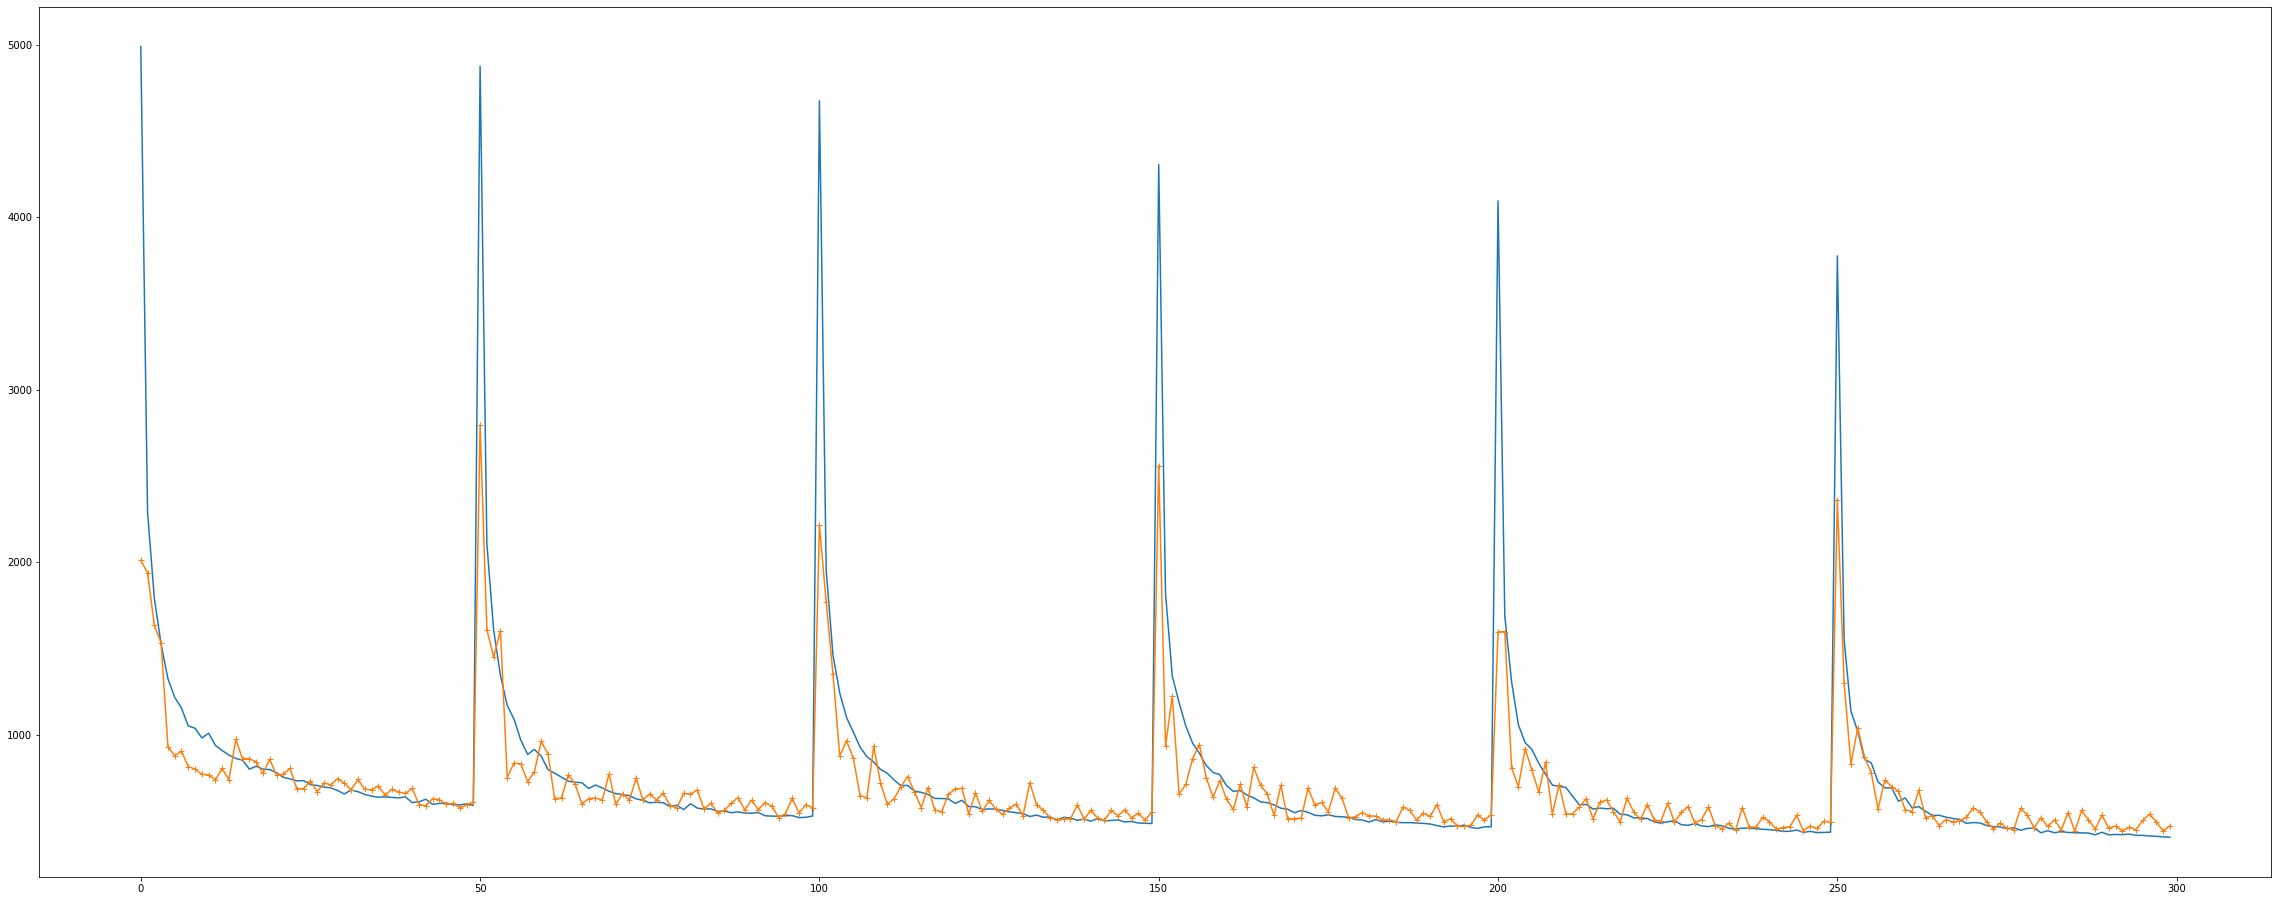

In [ ]:
mod,l1,l2 = history1
plt.plot(loss1,label='train_loss')
plt.plot(loss2, marker = '+',label='val_loss')

In [23]:
train_dataloader , val_dataloader, test_dataloader = prepare(['MOTHERSUMI','TATAPOWER','LUMAXTECH','DELTACORP','IBULHSGFIN','IDEA','BANKBARODA','JKTYRE'],min_max=True, batch =32, shuffle =True)

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volu

In [ ]:
EPOCHS = 50
LEARNING_RATE = 8e-4
loss_fn = tradeloss_2()
#loss_fn = nn.MSELoss()
#loss_fn = nn.SmoothL1Loss()
loss1 = []
loss2 = []
for i in range(8):
  print(f"P EPOCH = {i+1}")
  optimizer = torch.optim.Adagrad(mod.parameters(),lr =LEARNING_RATE )
  LEARNING_RATE = LEARNING_RATE -(i*0.00001)
  if i >=4:
    loss_fn = tradeloss_2()
  #lr_sch= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  history1 = train(mod, train_dataloader,val_dataloader,EPOCHS , optimizer,loss_fn,scheduler=None,
          name="lstm_nov_11_4f3.pth")
  mod, l1,l2 = history1
  loss1 = loss1 + l1
  loss2 = loss2 + l2

eval(mod,test_dataloader,loss_fn)

P EPOCH = 1
Epoch: 1/50
		Going for validation
	Train loss:29.620382.. 	Valid Loss:19.180316..
	Validation loss decreased (inf --> 19.180316).  Saving model ...
	Epoch:1 completed in 0m 24s
Epoch: 2/50
		Going for validation
	Train loss:17.237290.. 	Valid Loss:14.479339..
	Validation loss decreased (19.180316 --> 14.479339).  Saving model ...
	Epoch:2 completed in 0m 24s
Epoch: 3/50
		Going for validation
	Train loss:14.678081.. 	Valid Loss:12.307459..
	Validation loss decreased (14.479339 --> 12.307459).  Saving model ...
	Epoch:3 completed in 0m 24s
Epoch: 4/50
		Going for validation
	Train loss:13.286910.. 	Valid Loss:11.177035..
	Validation loss decreased (12.307459 --> 11.177035).  Saving model ...
	Epoch:4 completed in 0m 24s
Epoch: 5/50
		Going for validation
	Train loss:12.275429.. 	Valid Loss:11.064980..
	Validation loss decreased (11.177035 --> 11.064980).  Saving model ...
	Epoch:5 completed in 0m 24s
Epoch: 6/50
		Going for validation
	Train loss:11.622962.. 	Valid Loss:9.7

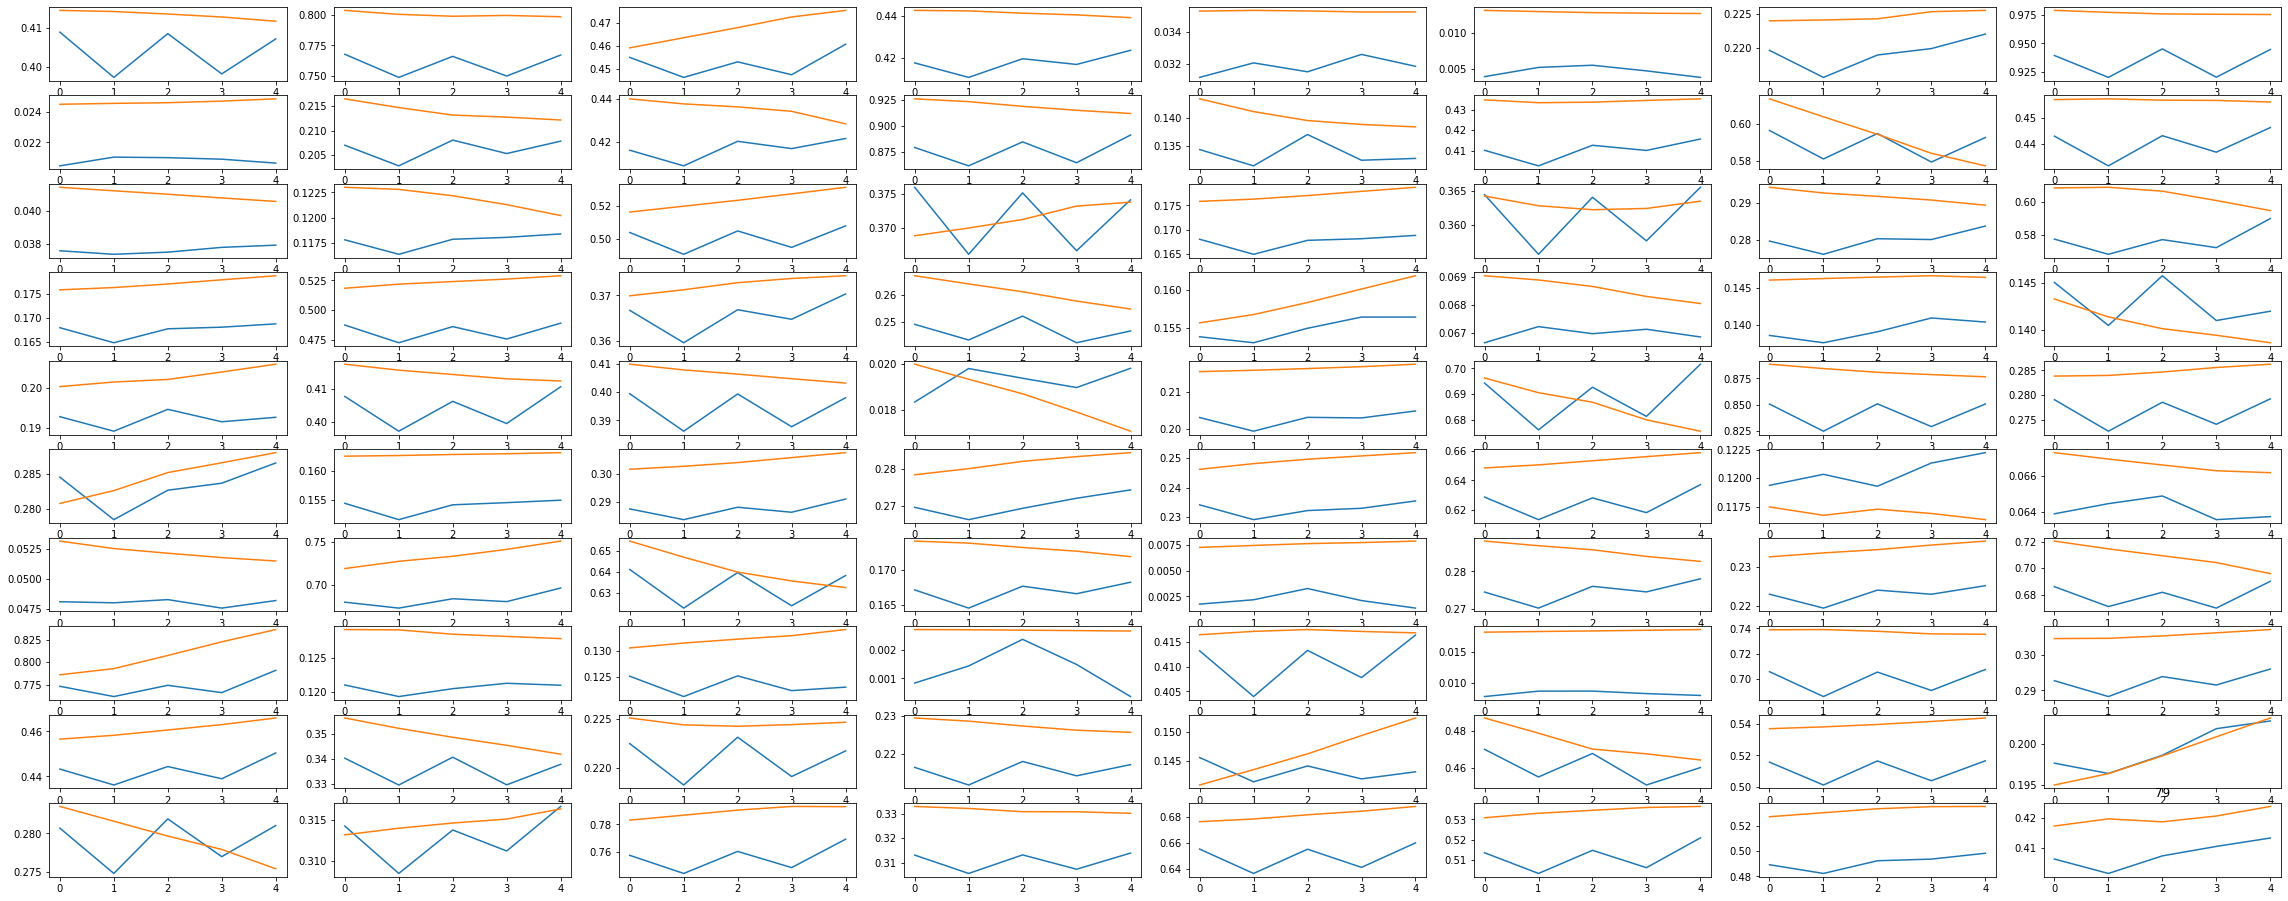

In [ ]:
mod = load_latest_model(mod,name="res_11_10f1.pth")
plot_data(mod,train_dataloader,random_range = 2298, randomized = True,days=5)

In [ ]:
load_latest_model(mod,name2,path)
loss_fn = tradeloss()
eval(mod,test_loader=test_dataloader,loss_fn=loss_fn)
loss_fn = tradeloss_2()
eval(mod,test_loader=test_dataloader,loss_fn=loss_fn)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)



Mean loss: 20.837929926420514

Mean loss: 15.726328874889173


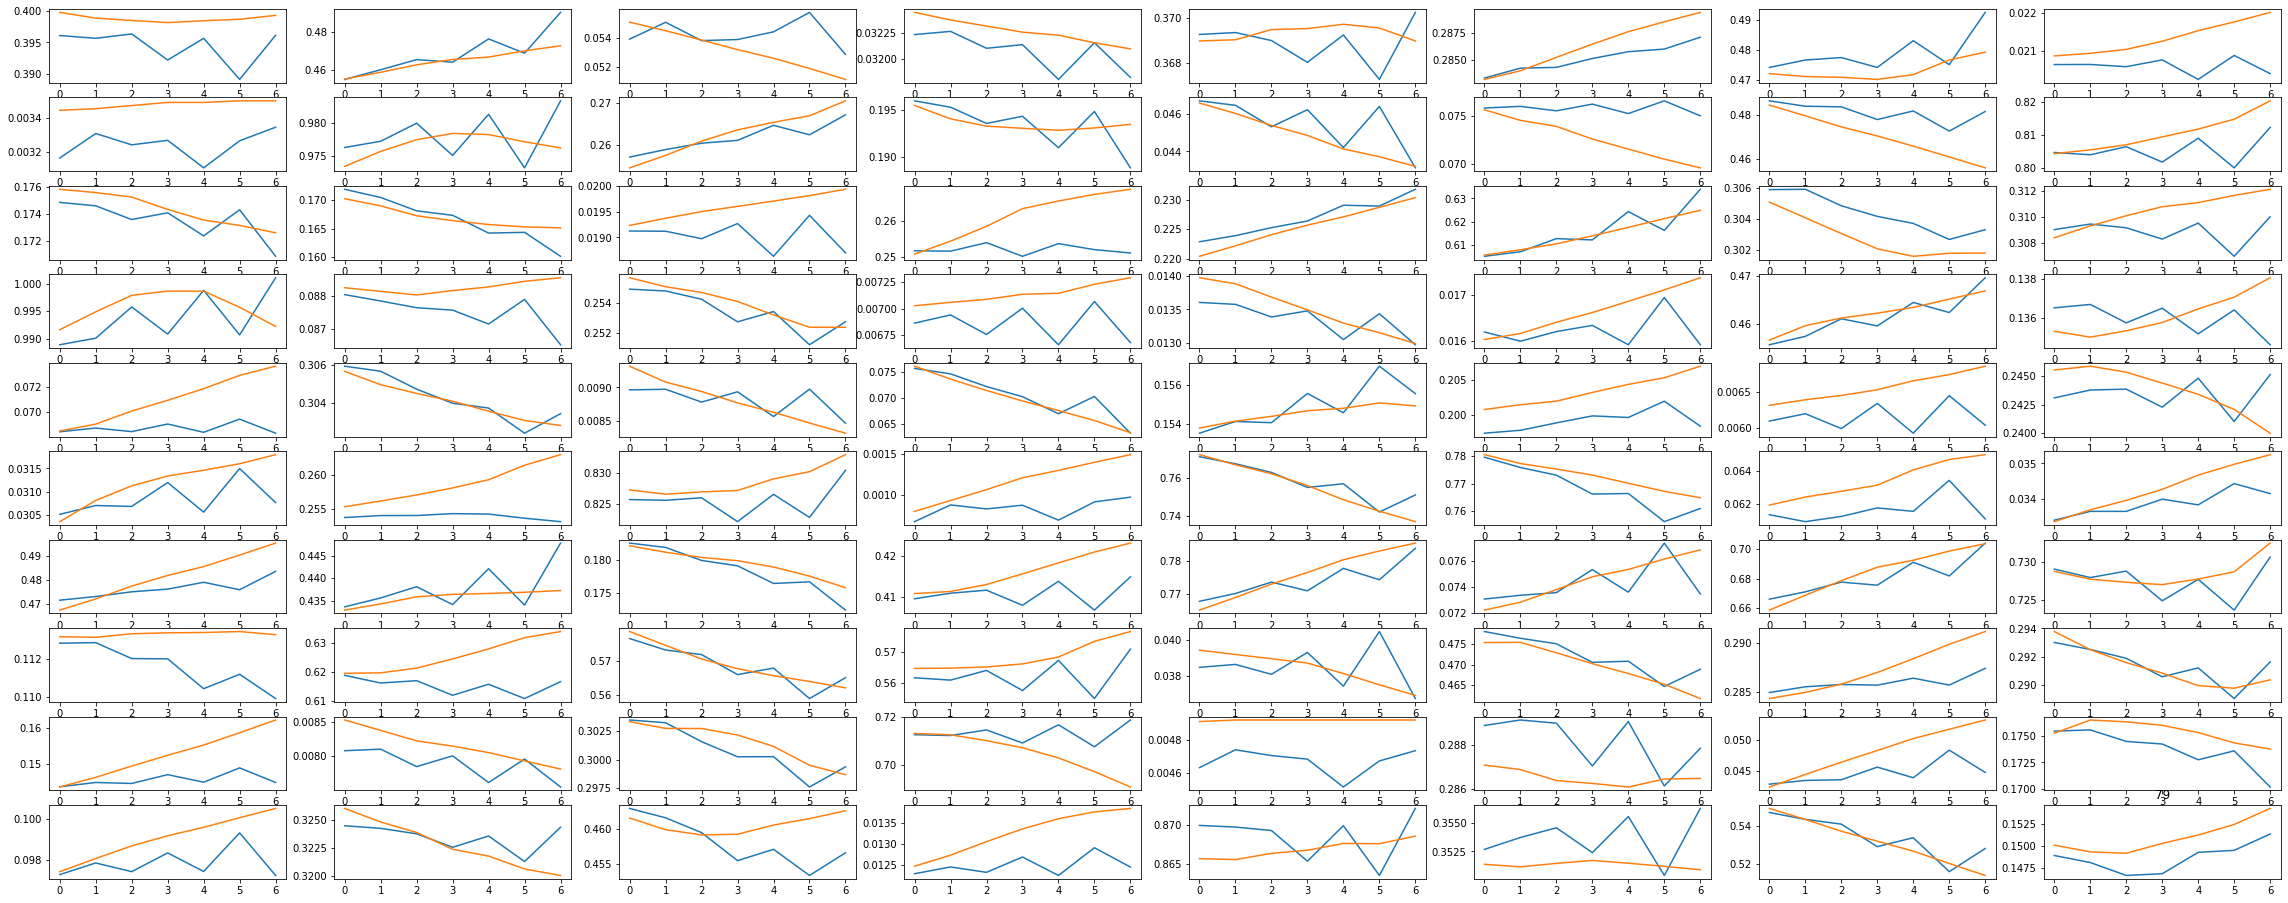

In [ ]:
plot_data(mod,val_dataloader, random_range=500)

In [ ]:
train_dataloader , val_dataloader, test_dataloader = prepare(['MOTHERSUMI'],min_max=True, batch =32, shuffle = False)

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(4657, 100, 5)
len x_train (3744, 100, 5), y_train 3744; x_val(416, 100, 5); y val 416 ; x test (448, 100, 5) y test 448


(3168, 110)


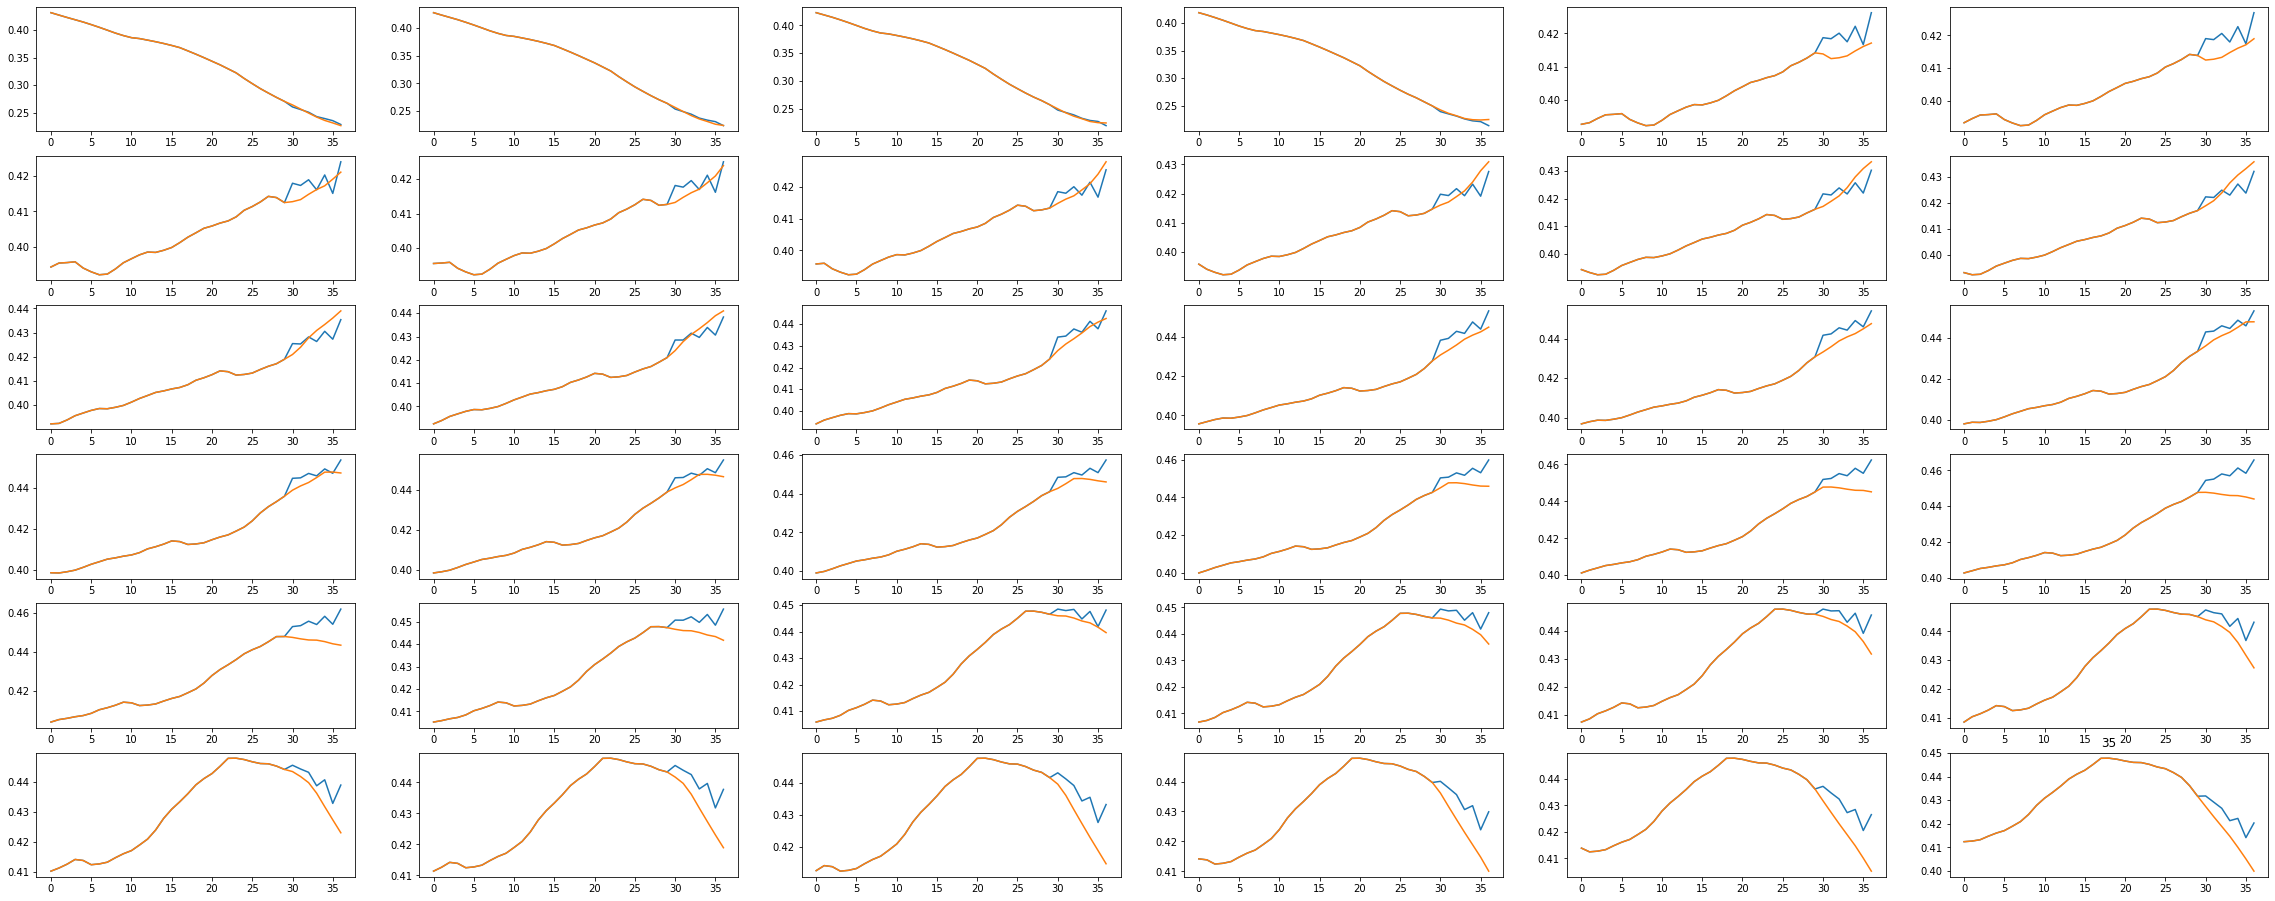

In [ ]:
plot_charts(mod,test_dataloader,row=6,col=6,days=70 ,random_range=412,randomized=False)

In [ ]:
data = StockData('MOTHERSUMI',min_max=True)

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')


In [ ]:
df = data.data

In [ ]:
plt.rcParams["figure.figsize"] = (40,10)


[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')


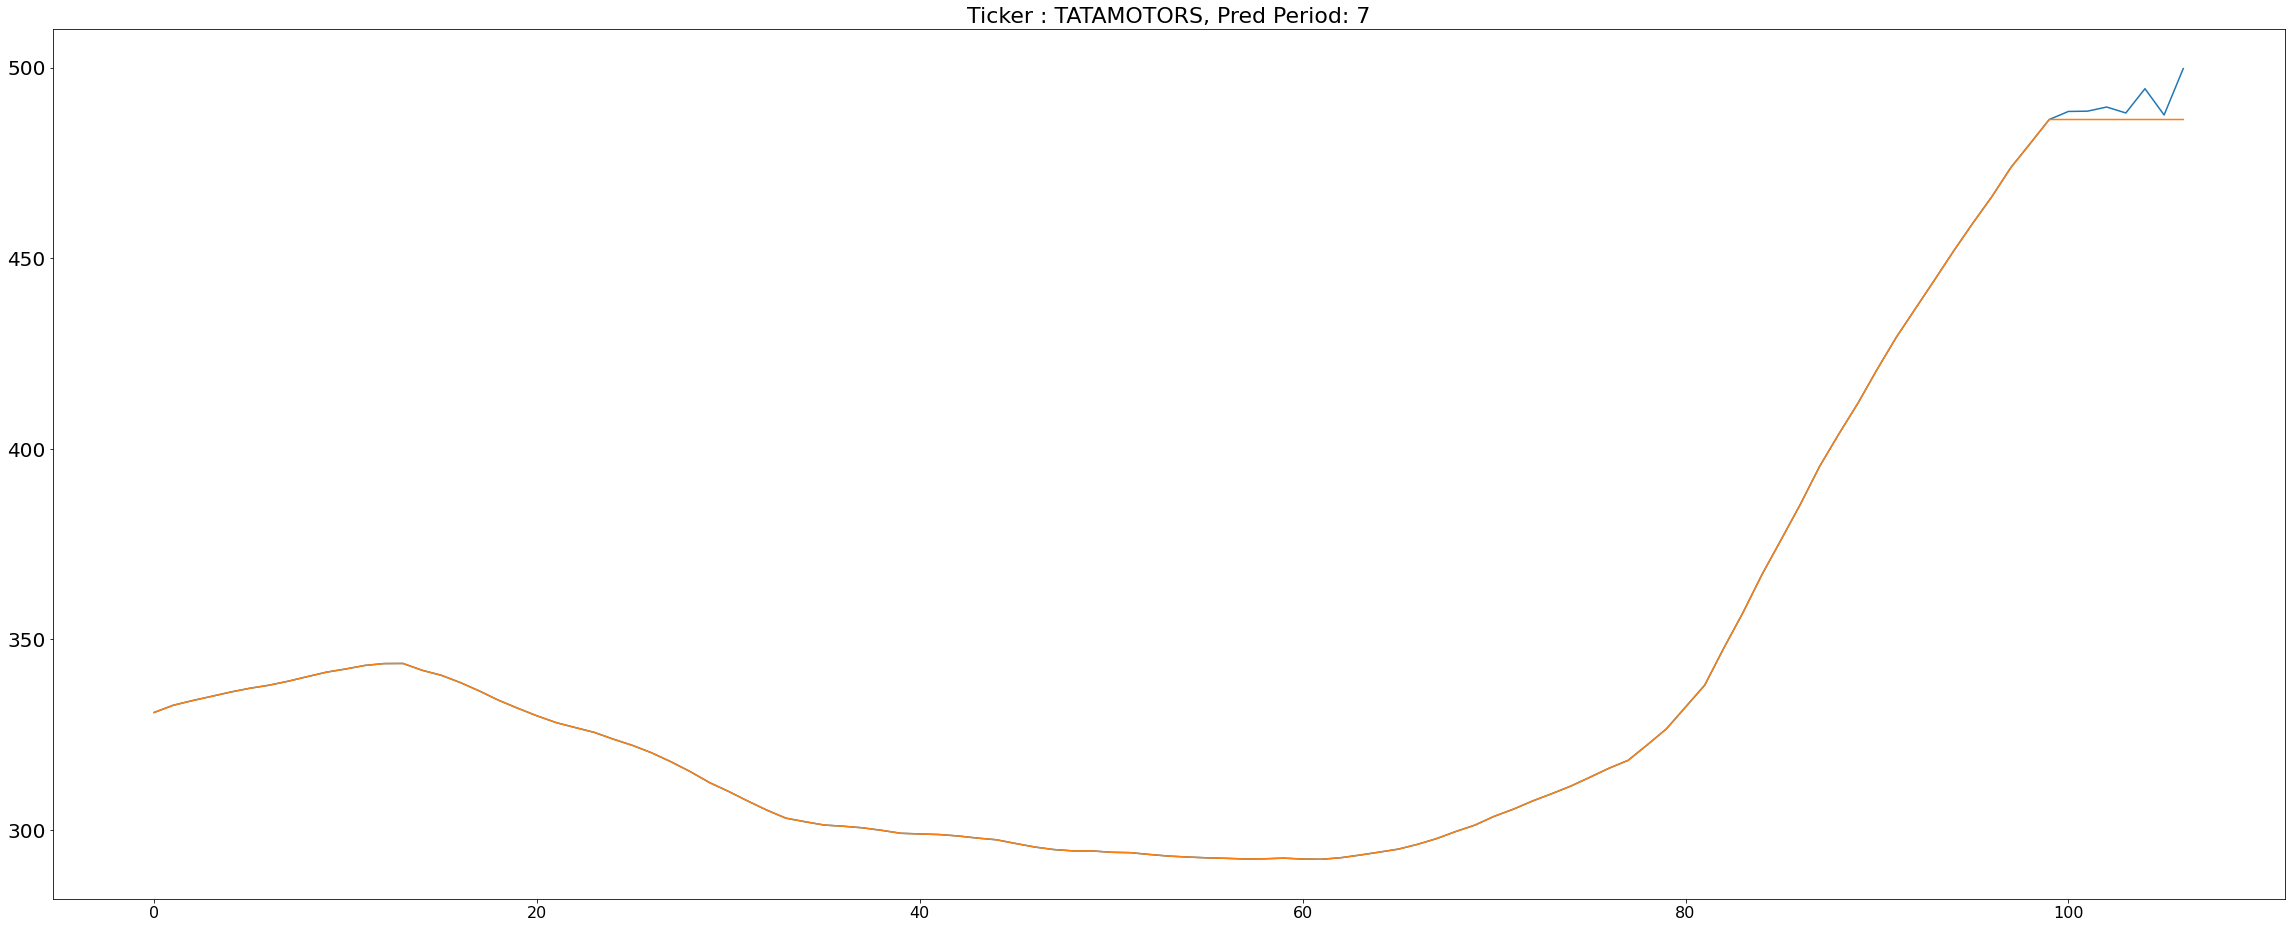

In [ ]:
chart_todays("TATAMOTORS",mod,days_leave=3)

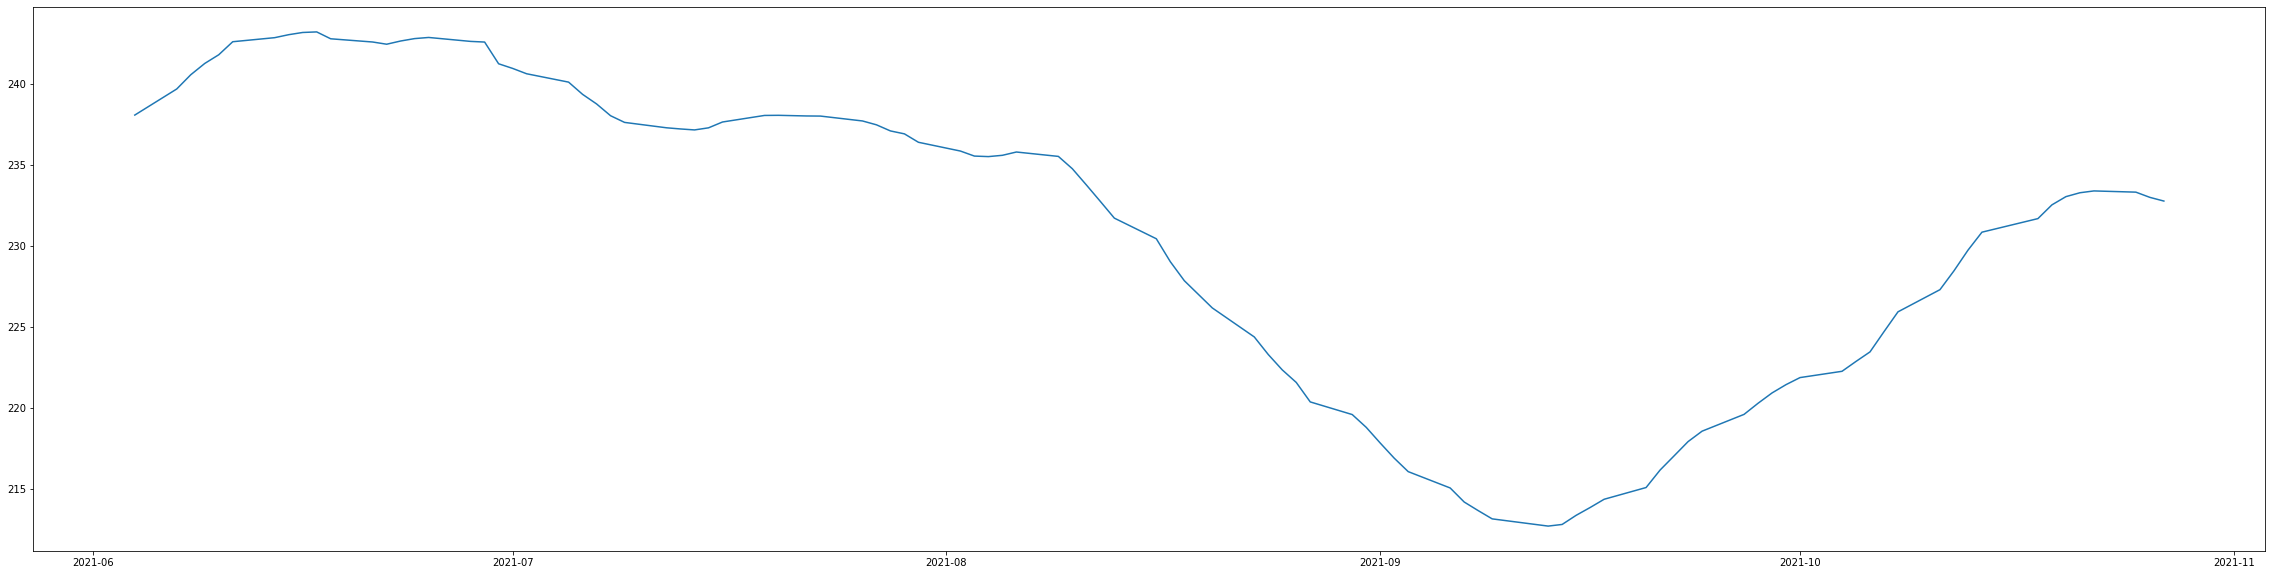

In [ ]:
plt.plot(df['Adj Close MA'][-100:])

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')


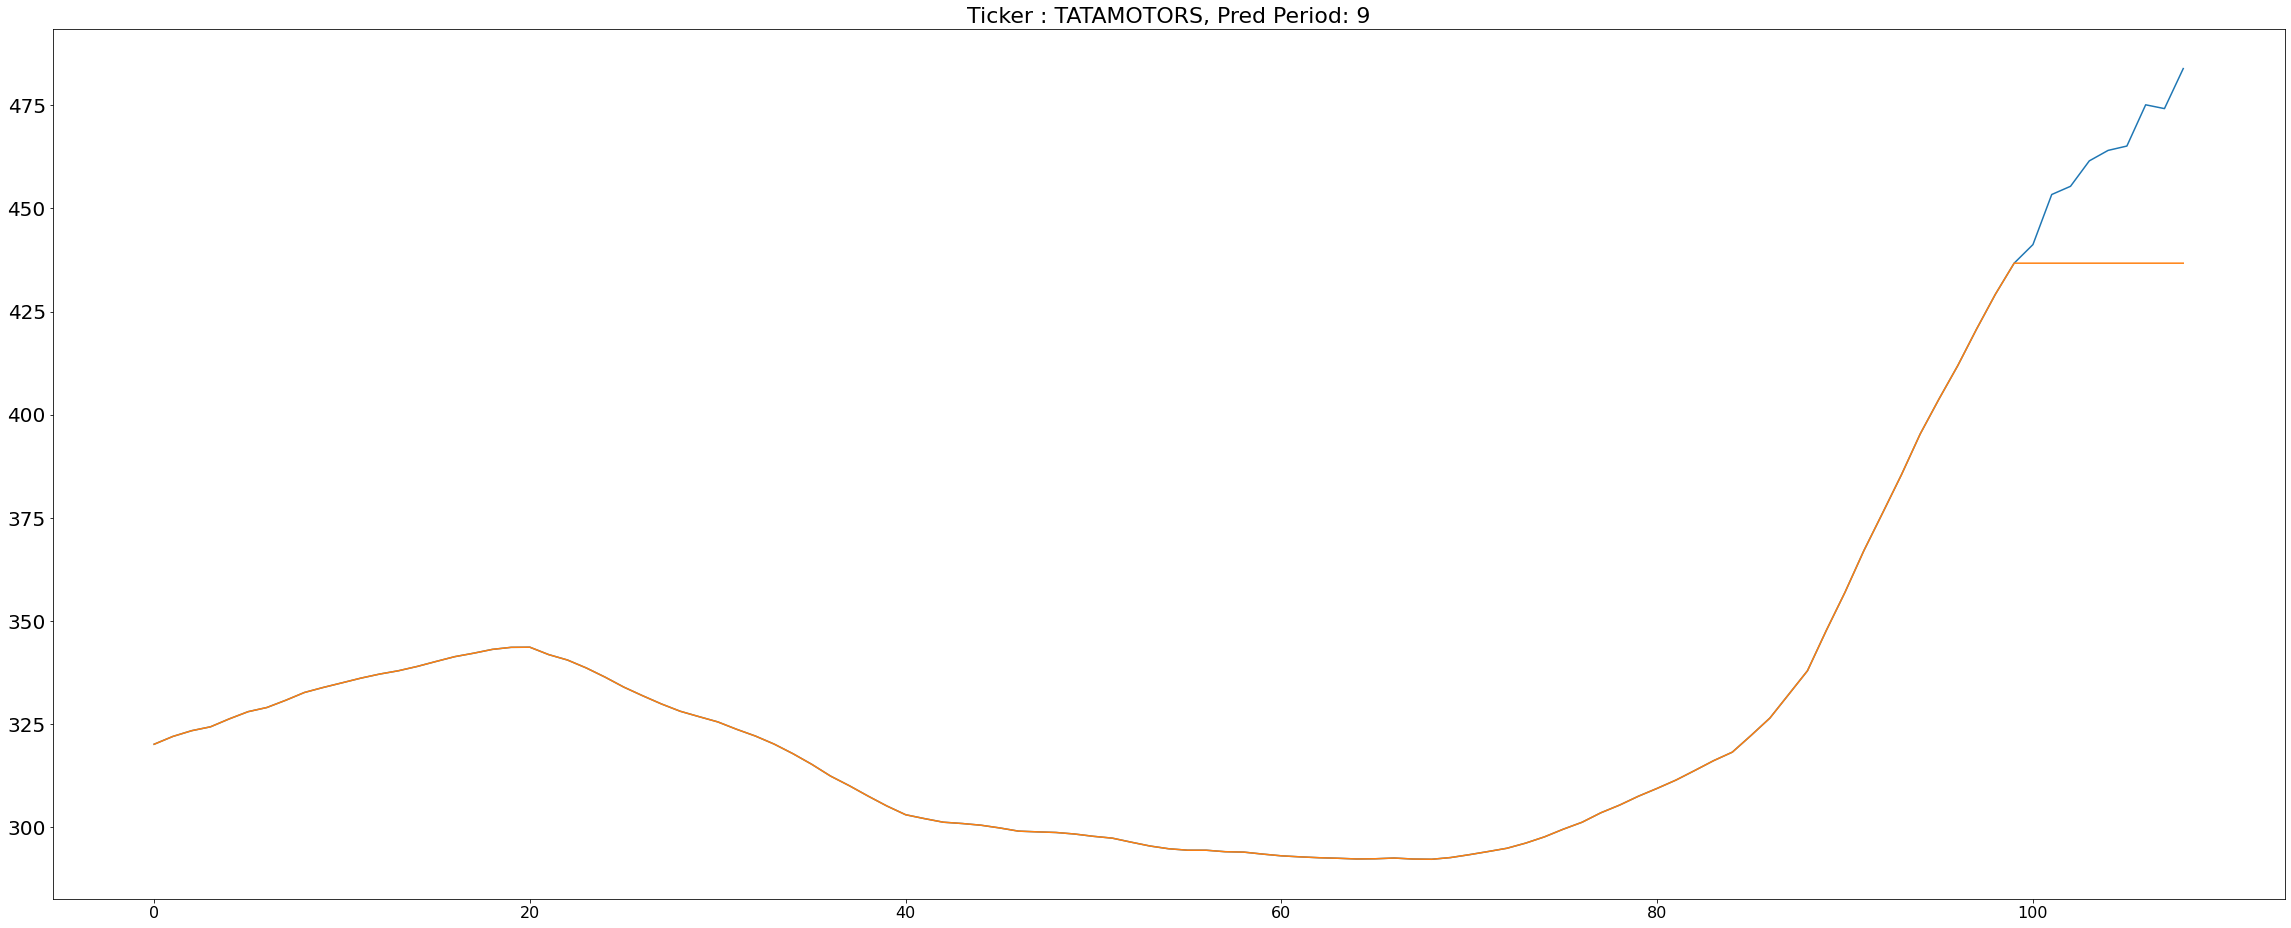

In [ ]:
chart_todays("TATAMOTORS",mod,days_leave=1)

In [ ]:
all_tickers = ['TATAMOTORS','ONGC','BPCL','INDUSINDBK','LT','IOC','ULTRACEMCO','TECHM']
all_tickers_2 = ['MOTHERSUMI','TATAPOWER','LUMAXTECH','DELTACORP','IBULHSGFIN','IDEA','BANKBARODA','JKTYRE']
etc = []


 TICKER: MOTHERSUMI

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(4659, 100, 5)
len x_train (3744, 100, 5), y_train 3744; x_val(416, 100, 5); y val 416 ; x test (448, 100, 5) y test 448
MEGA EPOCH = 1

Mean loss: 8.61658527300908
MEGA EPOCH = 2

Mean loss: 8.727282487429106
MEGA EPOCH = 3

Mean loss: 8.44289805338933
MEGA EPOCH = 4

Mean loss: 8.068403830895058
MEGA EPOCH = 5

Mean loss: 8.659773276402401
MEGA EPOCH = 6

Mean loss: 8.659773276402401

Mean loss: 9.319473368780953
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')

 TICKER: TATAPOWER

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(6353, 100, 5)
len x_train (5120, 100, 5), y_train 5120; x_val(544, 100, 5); y val 54

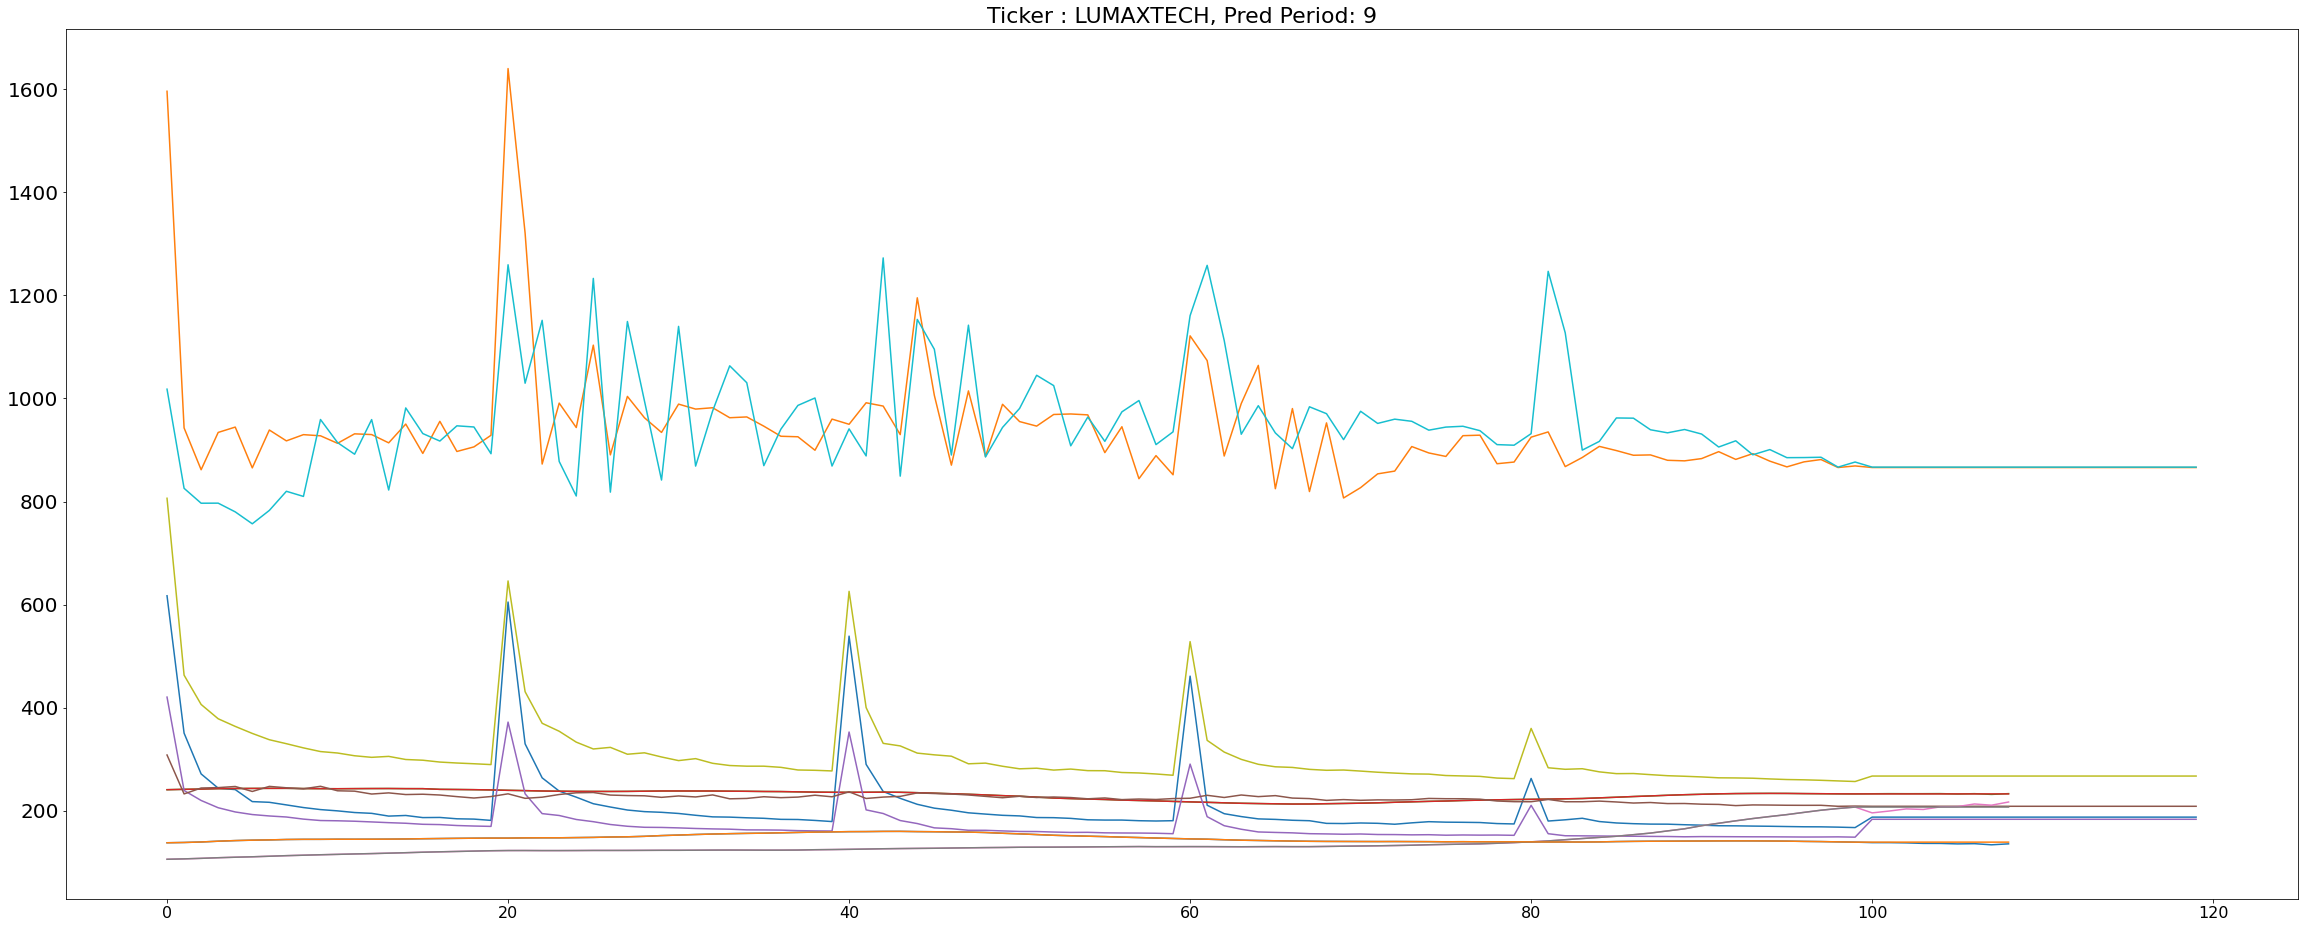

In [ ]:
for ticker in all_tickers:  
  print(f"\n TICKER: {ticker}\n" )
  EPOCHS = 20
  LEARNING_RATE = 1e-4
  loss_fn = tradeloss()
  #loss_fn = nn.MSELoss()
  #loss_fn = nn.SmoothL1Loss()
  loss1 = []
  loss2 = []
  train_dataloader , val_dataloader, test_dataloader = prepare([ticker],min_max=True, batch =32, shuffle = False)
  modx = CNND(32)
  modx = load_latest_model(mod,name)
  for i in range(6):
    print(f"MEGA EPOCH = {i+1}")
    optimizer = torch.optim.Adagrad(modx.parameters(),lr =LEARNING_RATE )
    LEARNING_RATE = LEARNING_RATE - i*0.00001
    #lr_sch= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    history1 = train(modx, train_dataloader,val_dataloader,EPOCHS , optimizer,loss_fn,scheduler=None,verbose=False,
          name=f"cdd1_td1_nov_{ticker}.pth", path=path)
    modx, l1,l2 = history1
    loss1 = loss1 + l1
    loss2 = loss2 + l2
    eval(modx,val_dataloader,loss_fn)
  plt.plot(loss1)
  plt.plot(loss2)
  eval(modx,test_dataloader,loss_fn)
  chart_todays(ticker,modx,days_leave=1)

In [ ]:
load_latest_model(mod,name,path='/content/')
loss_fn = tradeloss()
eval(mod,test_loader=test_dataloader,loss_fn=loss_fn)
loss_fn = tradeloss_2()
eval(mod,test_loader=test_dataloader,loss_fn=loss_fn)

In [ ]:
models = []
for ticker in all_tickers_2:
  nme = ticker_model_name(ticker)
  load_latest_model(mod,nme,path)
  eval(mod,test_loader=test_dataloader,loss_fn=loss_fn)
  models.append(mod)


[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(107,)

Mean loss: 11.664410209655761

Mean loss: 14.372128105163574

Mean loss: 8.576361513137817

Mean loss: 12.515422773361205

Mean loss: 16.40086612701416

Mean loss: 11.384588289260865

Mean loss: 12.462892198562622

Mean loss: 14.628912734985352


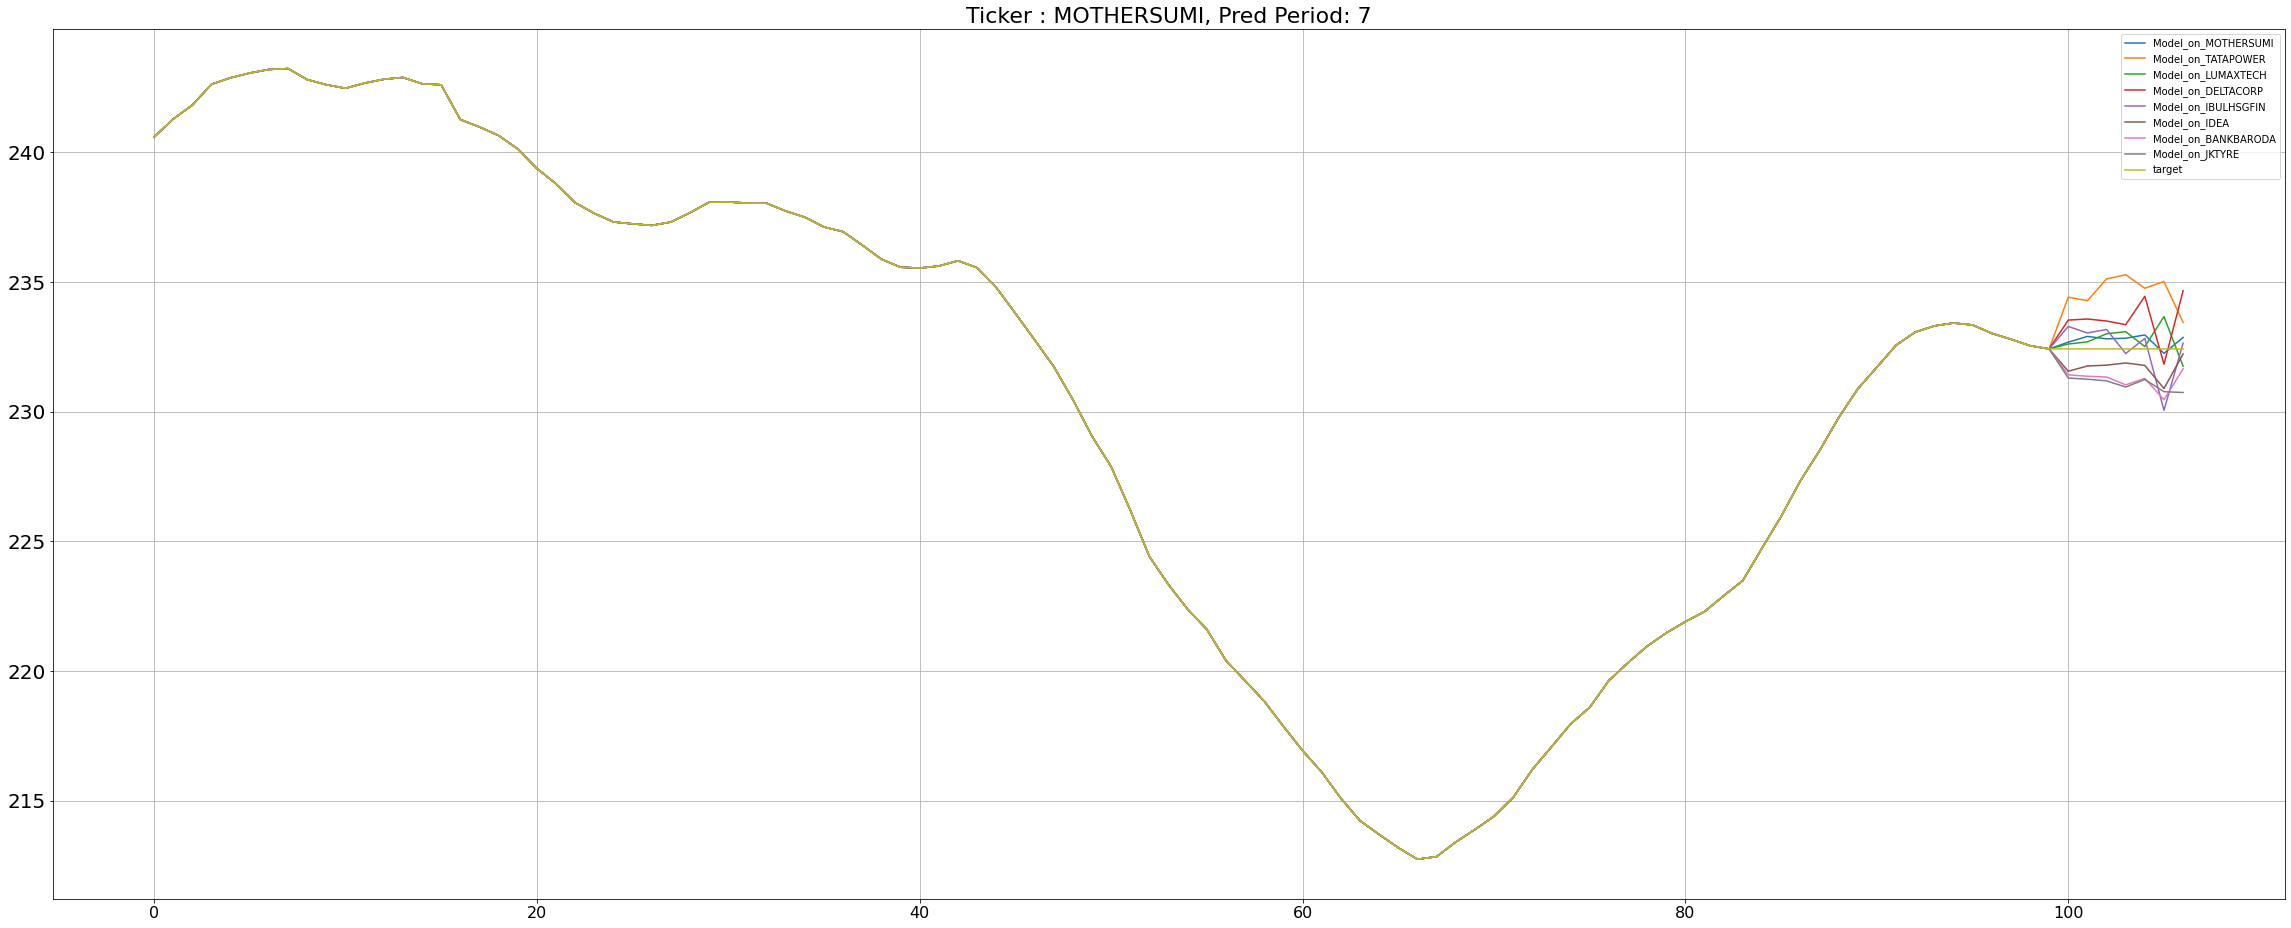




[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(107,)

Mean loss: 11.664410209655761

Mean loss: 14.372128105163574

Mean loss: 8.576361513137817

Mean loss: 12.515422773361205

Mean loss: 16.40086612701416

Mean loss: 11.384588289260865

Mean loss: 12.462892198562622

Mean loss: 14.628912734985352


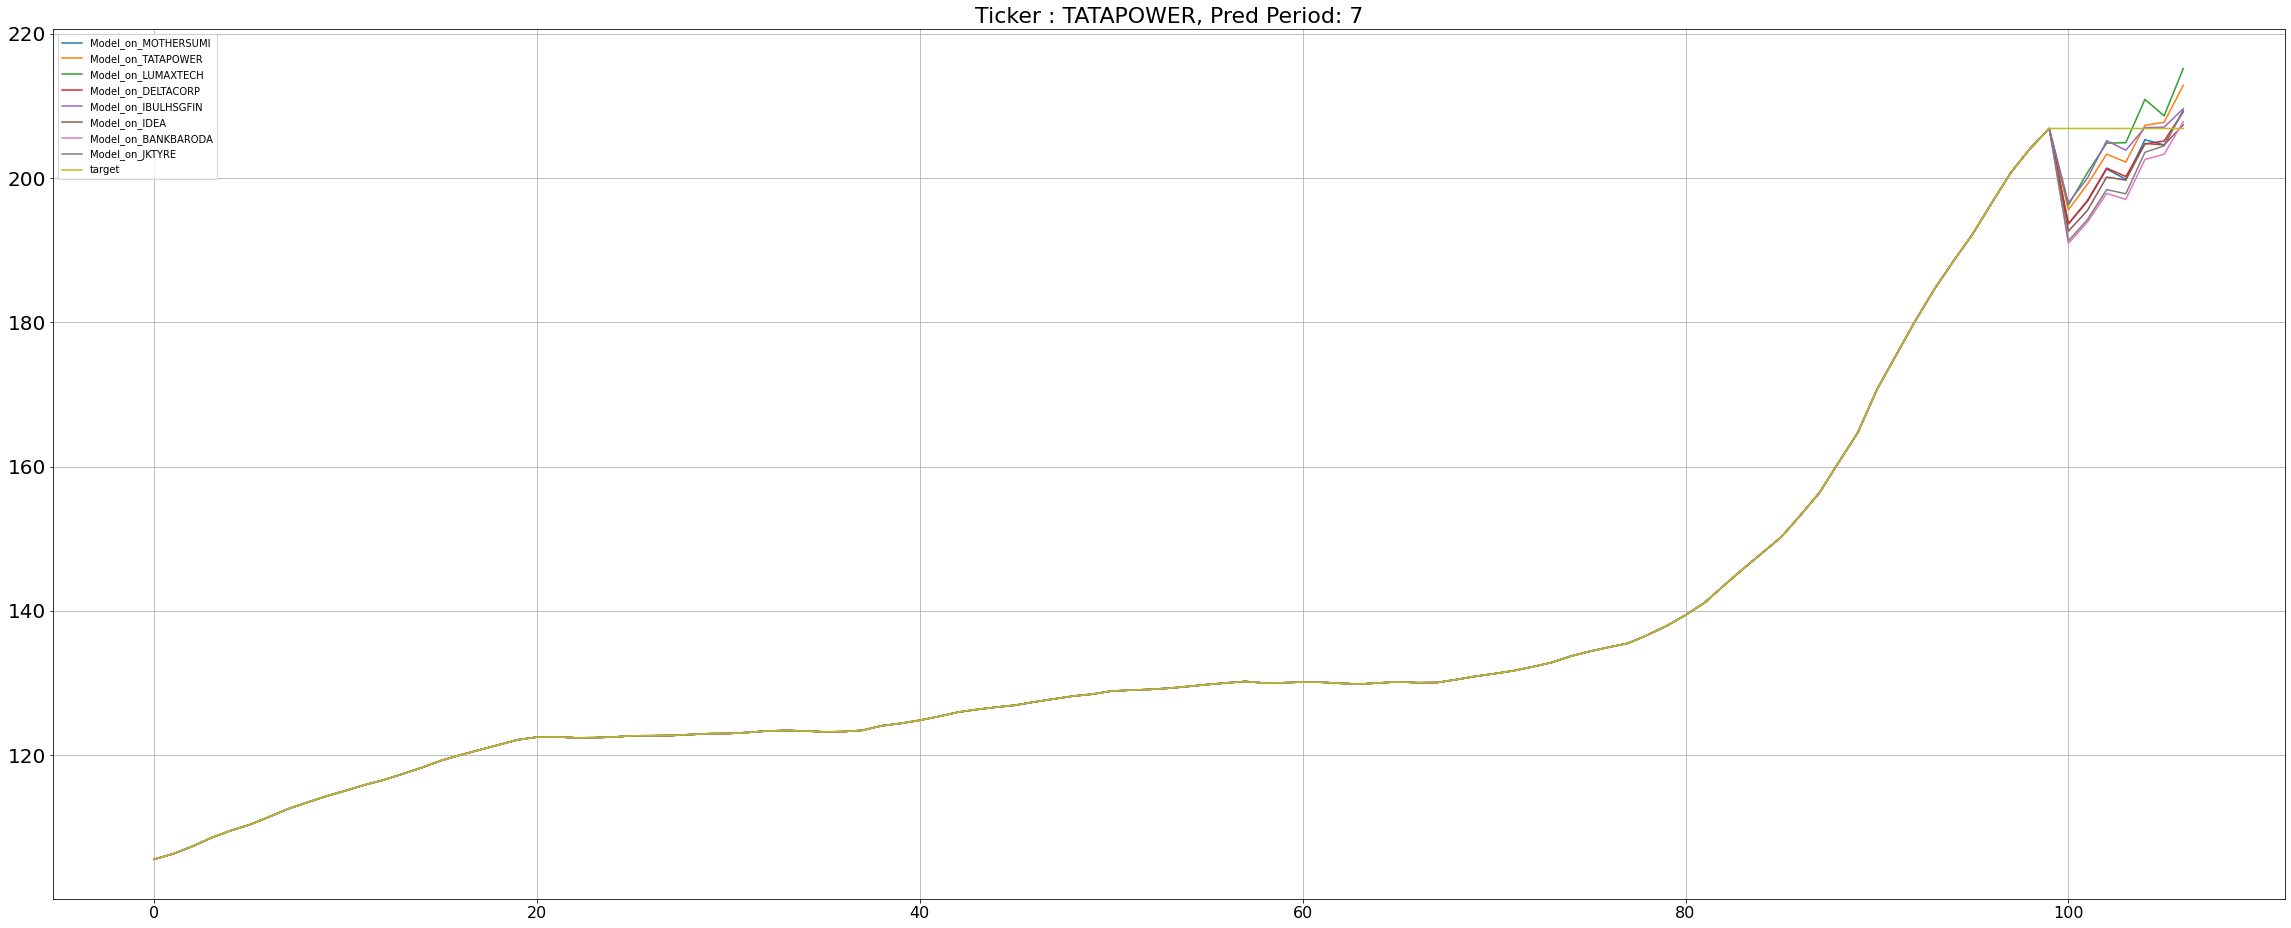




[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(107,)

Mean loss: 11.664410209655761

Mean loss: 14.372128105163574

Mean loss: 8.576361513137817

Mean loss: 12.515422773361205

Mean loss: 16.40086612701416

Mean loss: 11.384588289260865

Mean loss: 12.462892198562622

Mean loss: 14.628912734985352


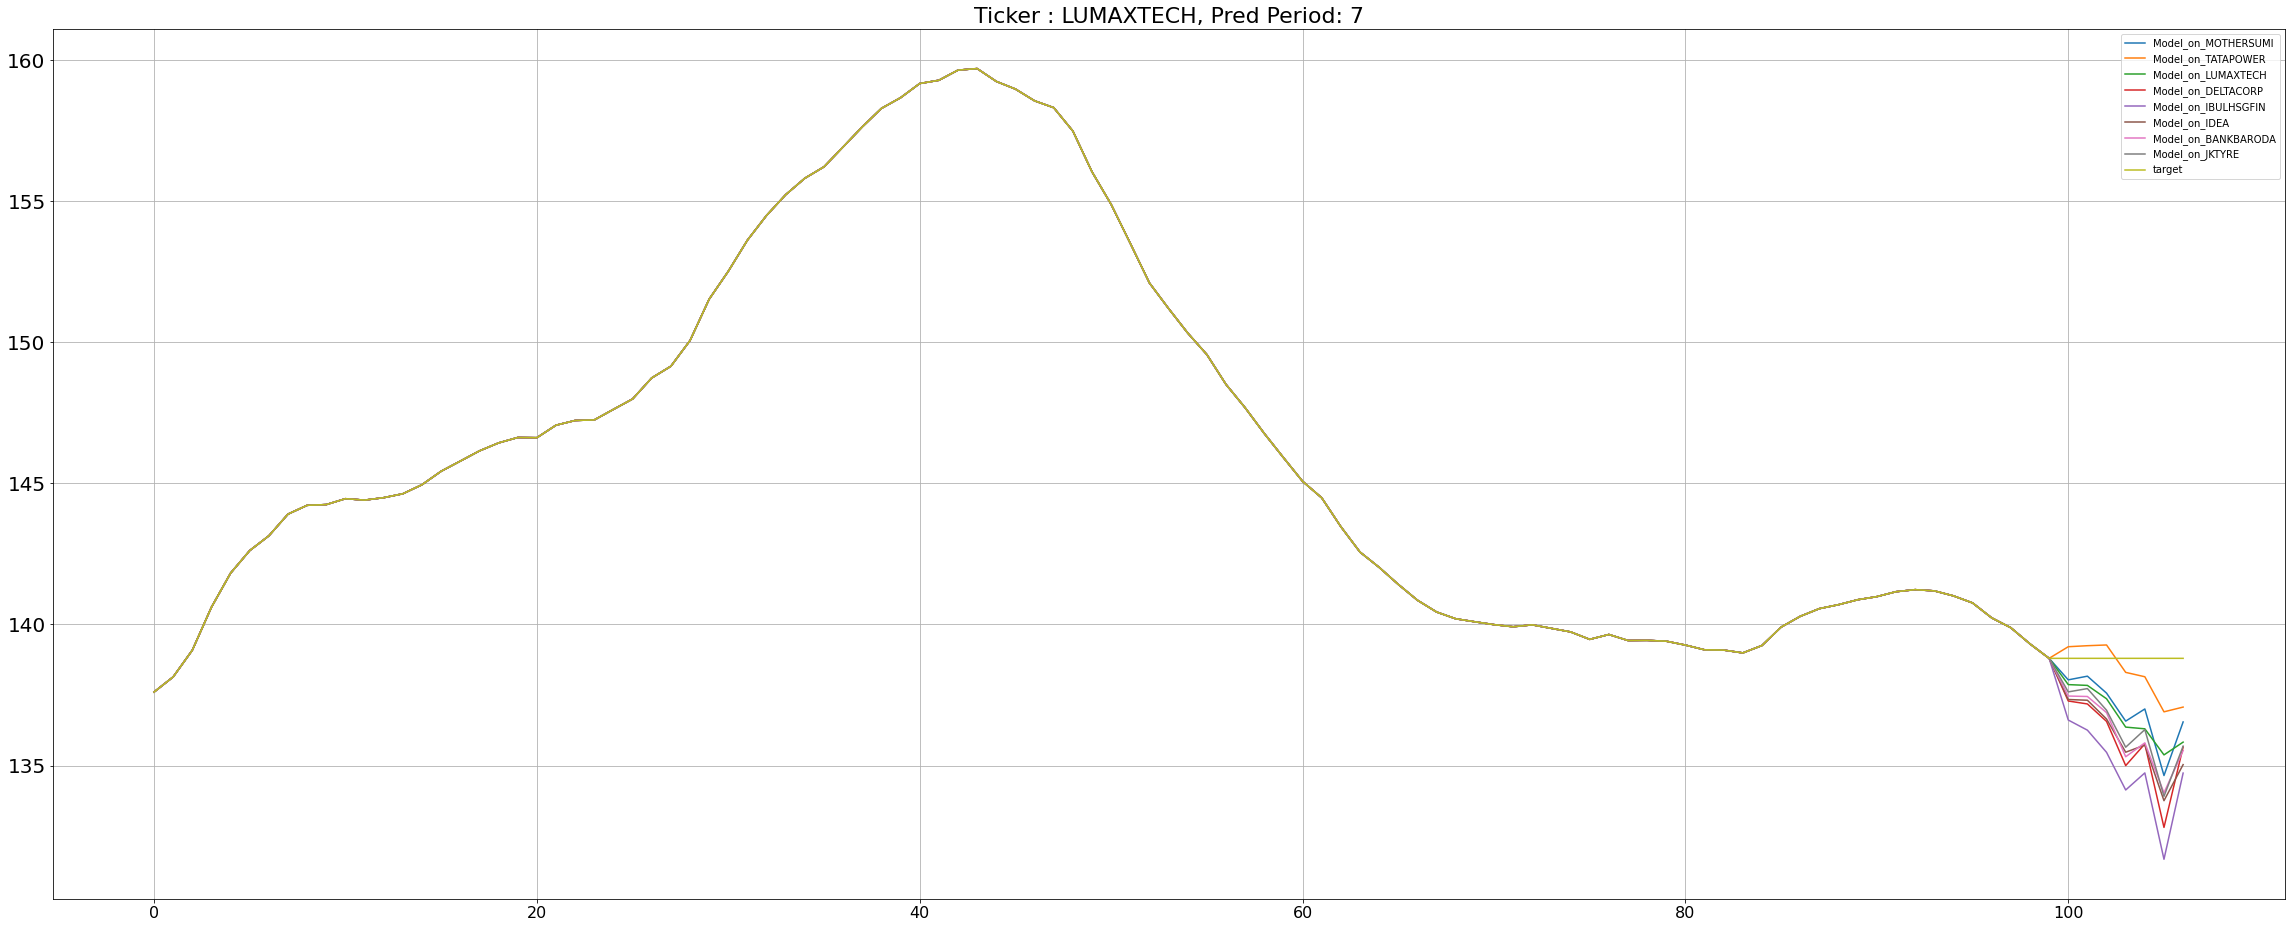




[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(107,)

Mean loss: 11.664410209655761

Mean loss: 14.372128105163574

Mean loss: 8.576361513137817

Mean loss: 12.515422773361205

Mean loss: 16.40086612701416

Mean loss: 11.384588289260865

Mean loss: 12.462892198562622

Mean loss: 14.628912734985352


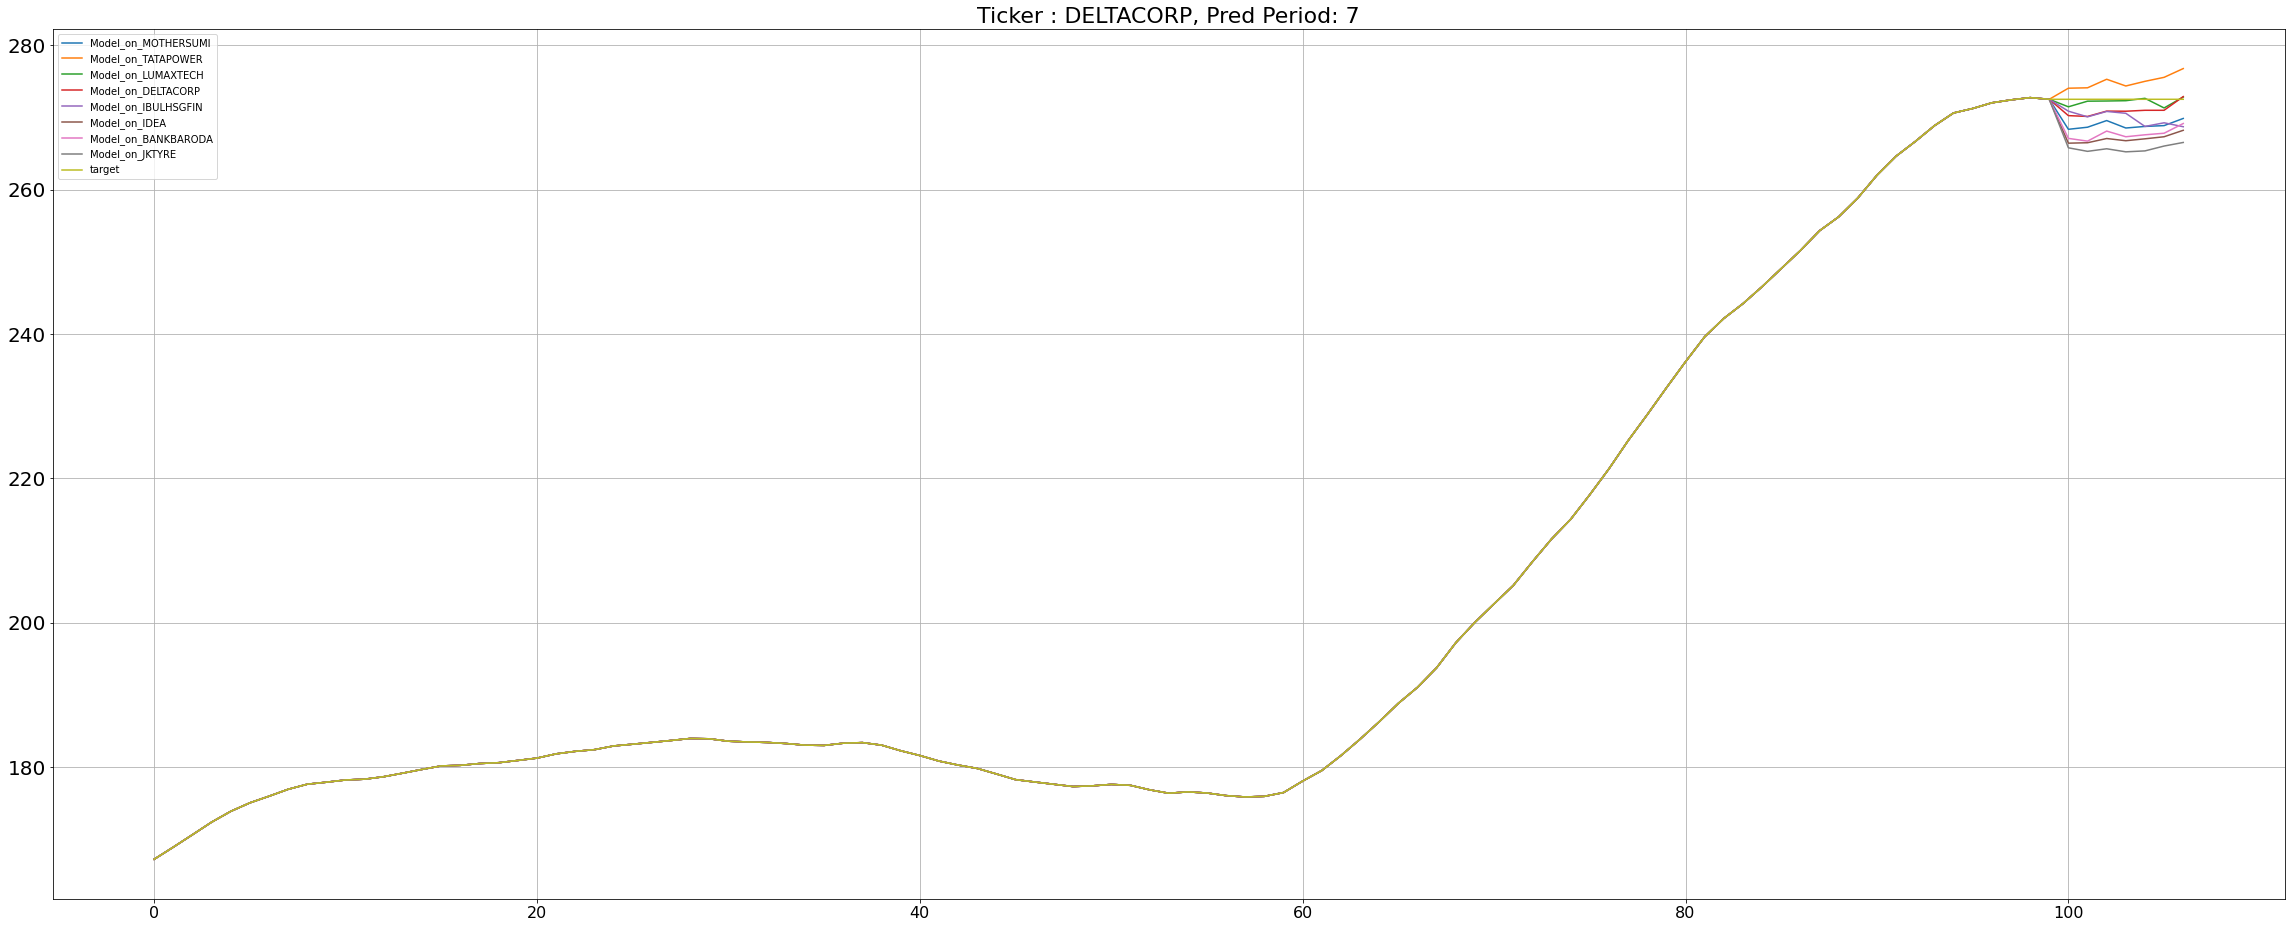




[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(107,)

Mean loss: 11.664410209655761

Mean loss: 14.372128105163574

Mean loss: 8.576361513137817

Mean loss: 12.515422773361205

Mean loss: 16.40086612701416

Mean loss: 11.384588289260865

Mean loss: 12.462892198562622

Mean loss: 14.628912734985352


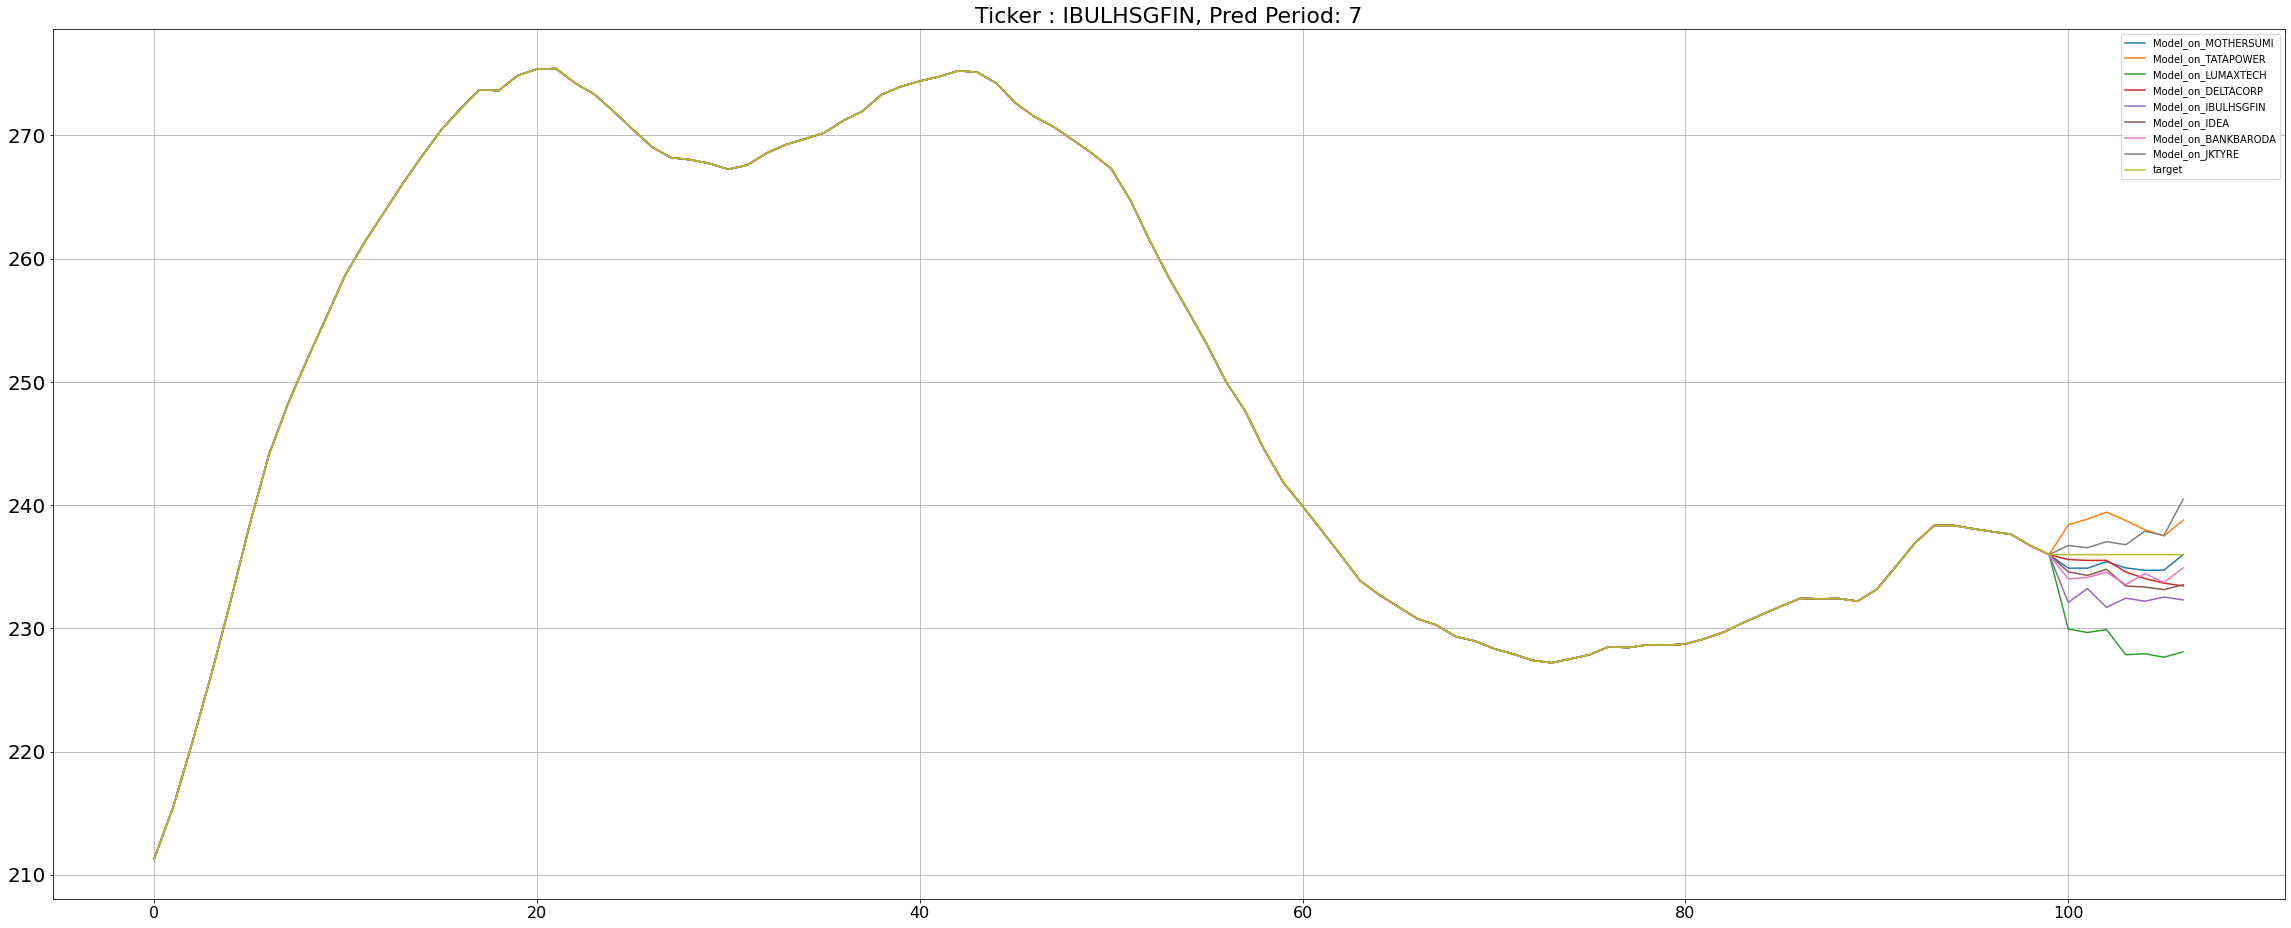




[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(107,)

Mean loss: 11.664410209655761

Mean loss: 14.372128105163574

Mean loss: 8.576361513137817

Mean loss: 12.515422773361205

Mean loss: 16.40086612701416

Mean loss: 11.384588289260865

Mean loss: 12.462892198562622

Mean loss: 14.628912734985352


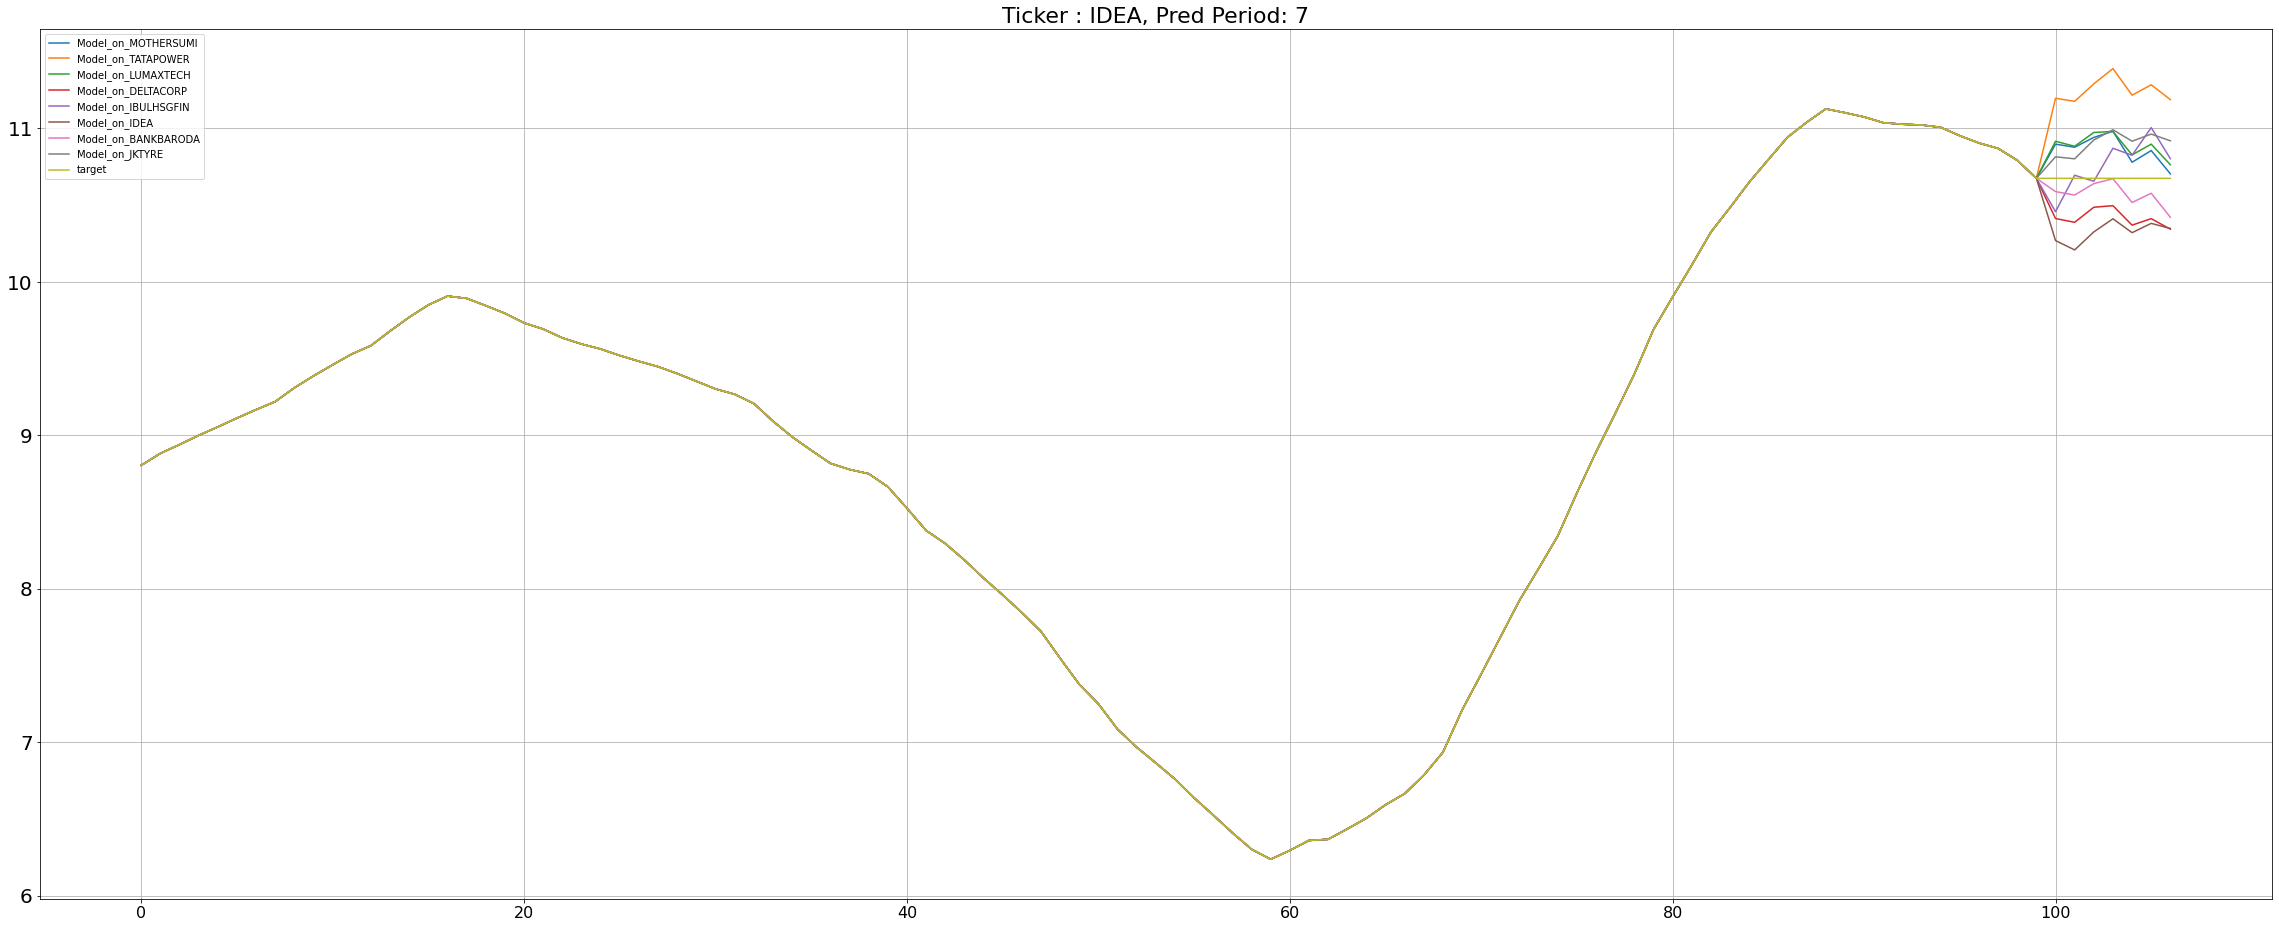




[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(107,)

Mean loss: 11.664410209655761

Mean loss: 14.372128105163574

Mean loss: 8.576361513137817

Mean loss: 12.515422773361205

Mean loss: 16.40086612701416

Mean loss: 11.384588289260865

Mean loss: 12.462892198562622

Mean loss: 14.628912734985352


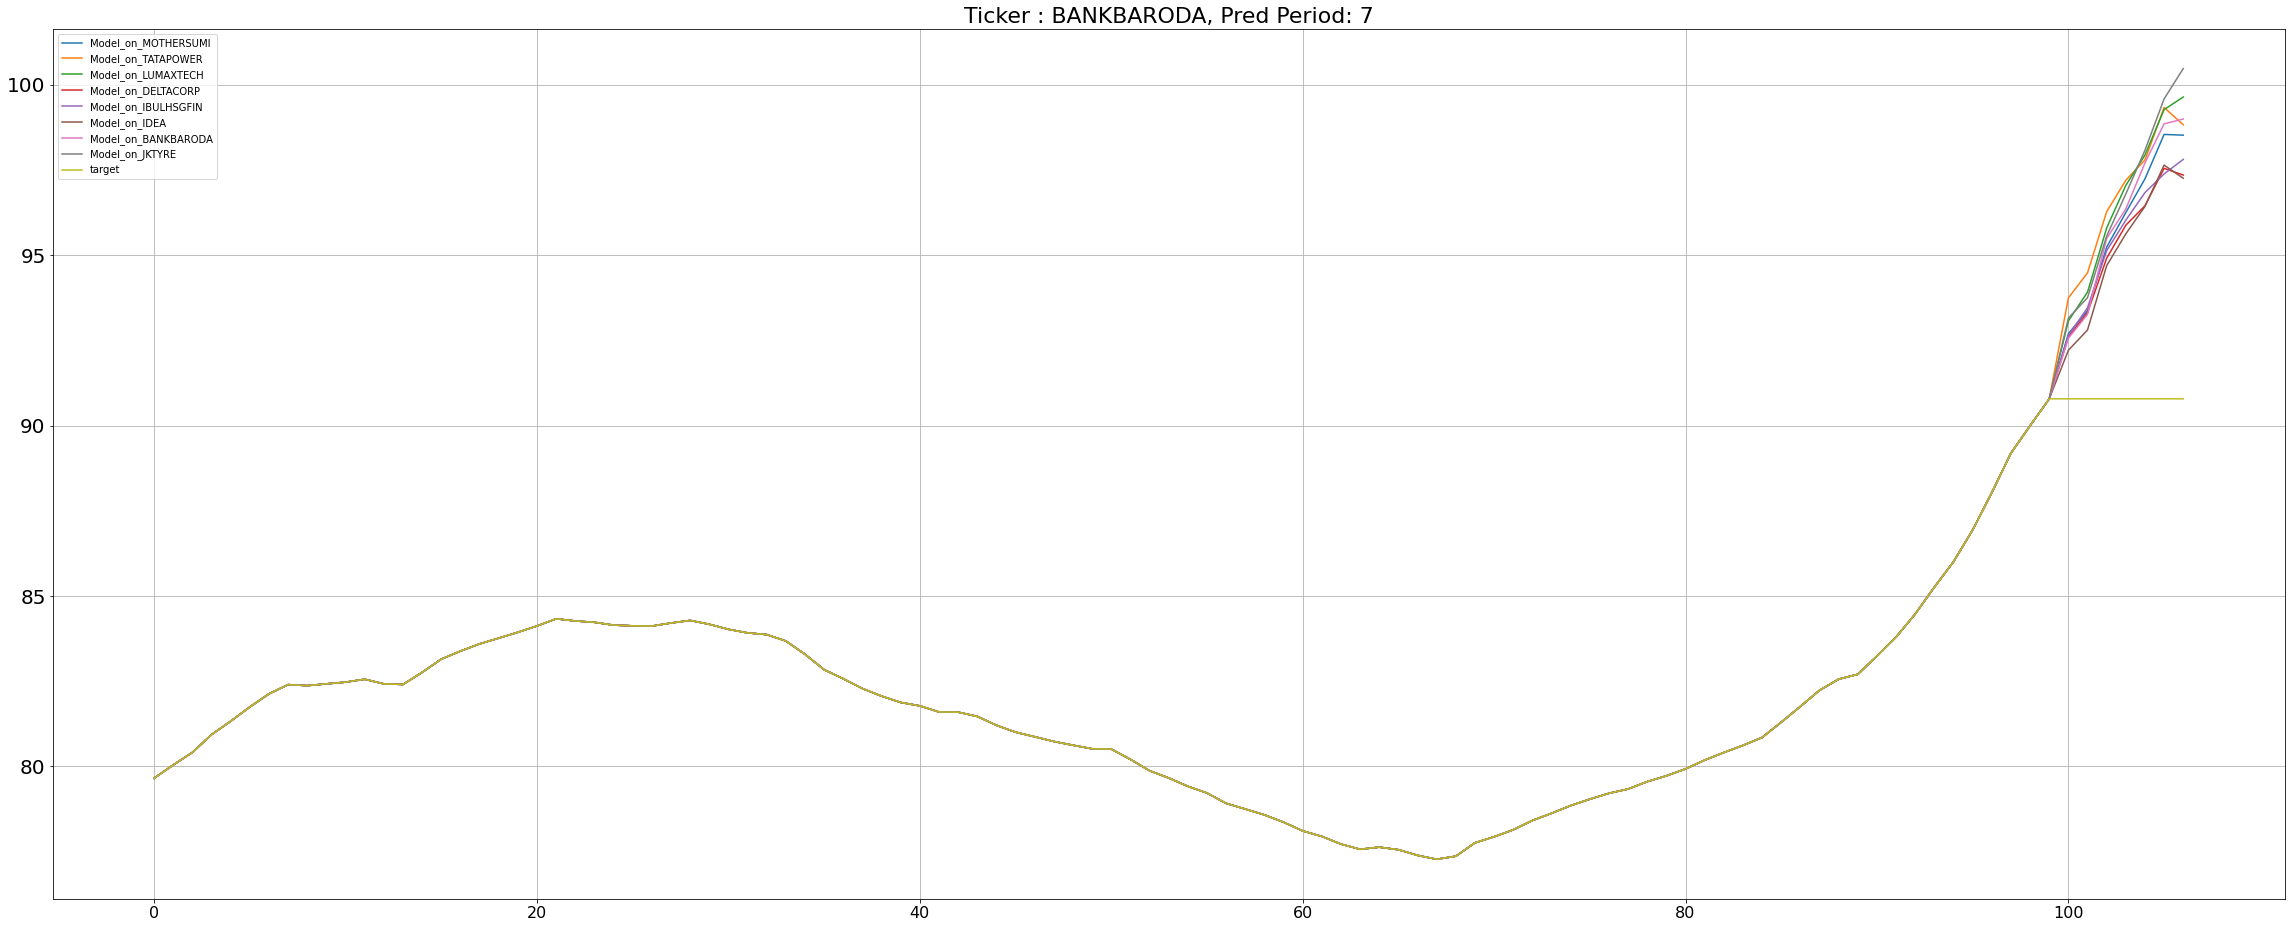




[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(107,)

Mean loss: 11.664410209655761

Mean loss: 14.372128105163574

Mean loss: 8.576361513137817

Mean loss: 12.515422773361205

Mean loss: 16.40086612701416

Mean loss: 11.384588289260865

Mean loss: 12.462892198562622

Mean loss: 14.628912734985352


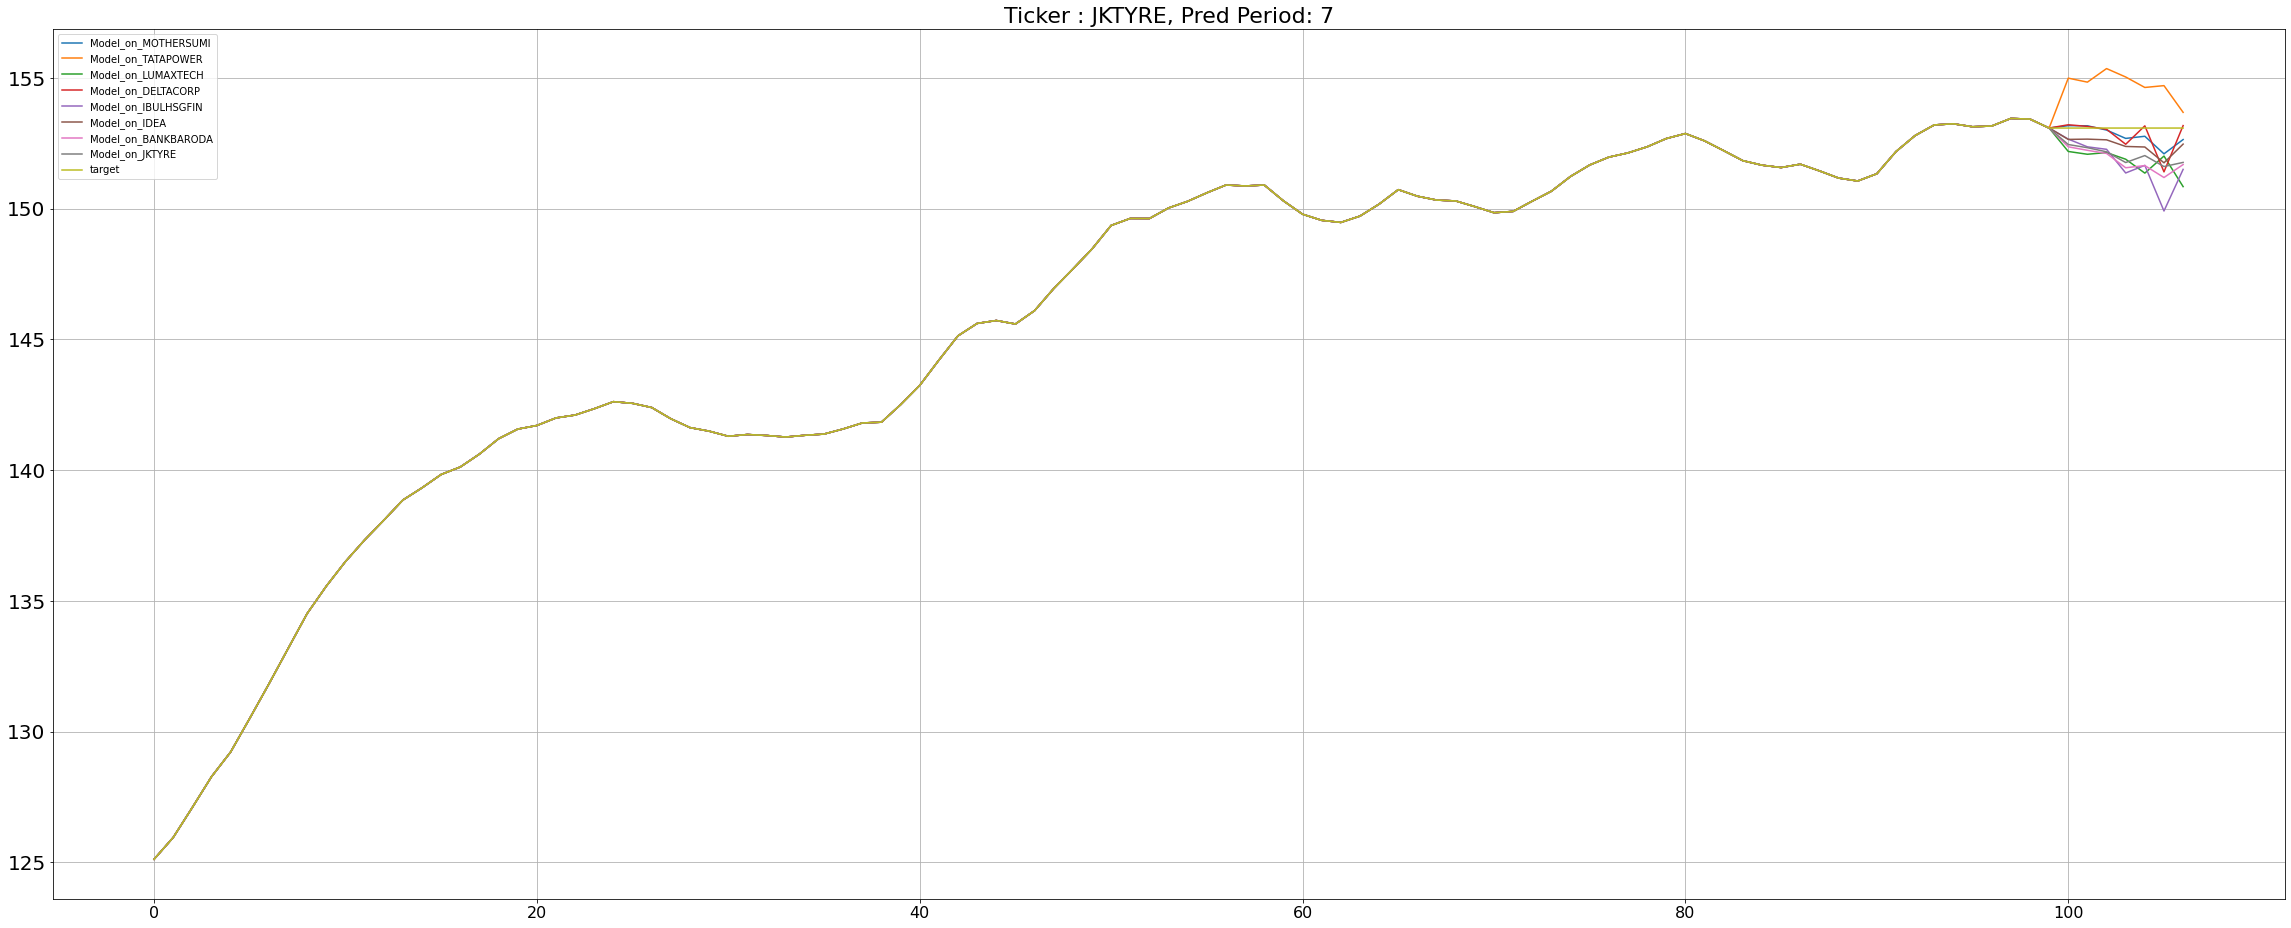

In [ ]:
for ticker in all_tickers_2:
  n_model_chart_todays(ticker=f"{ticker}",models=mod,t_model_names=all_tickers_2,path=path,days_cutoff = 1000,days_leave=3,pred_period=10,)
  print("\n\n")

In [ ]:
for modt in models:
  eval(modt,test_loader=test_dataloader,loss_fn=loss_fn)

In [ ]:
m

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(107,)

Mean loss: 13.767404152796818

Mean loss: 17.197481888991135

Mean loss: 15.762643227210411

Mean loss: 22.30690781886761

Mean loss: 20.38539226238544

Mean loss: 15.573915316508366

Mean loss: 18.927607756394607

Mean loss: 19.44290475203441


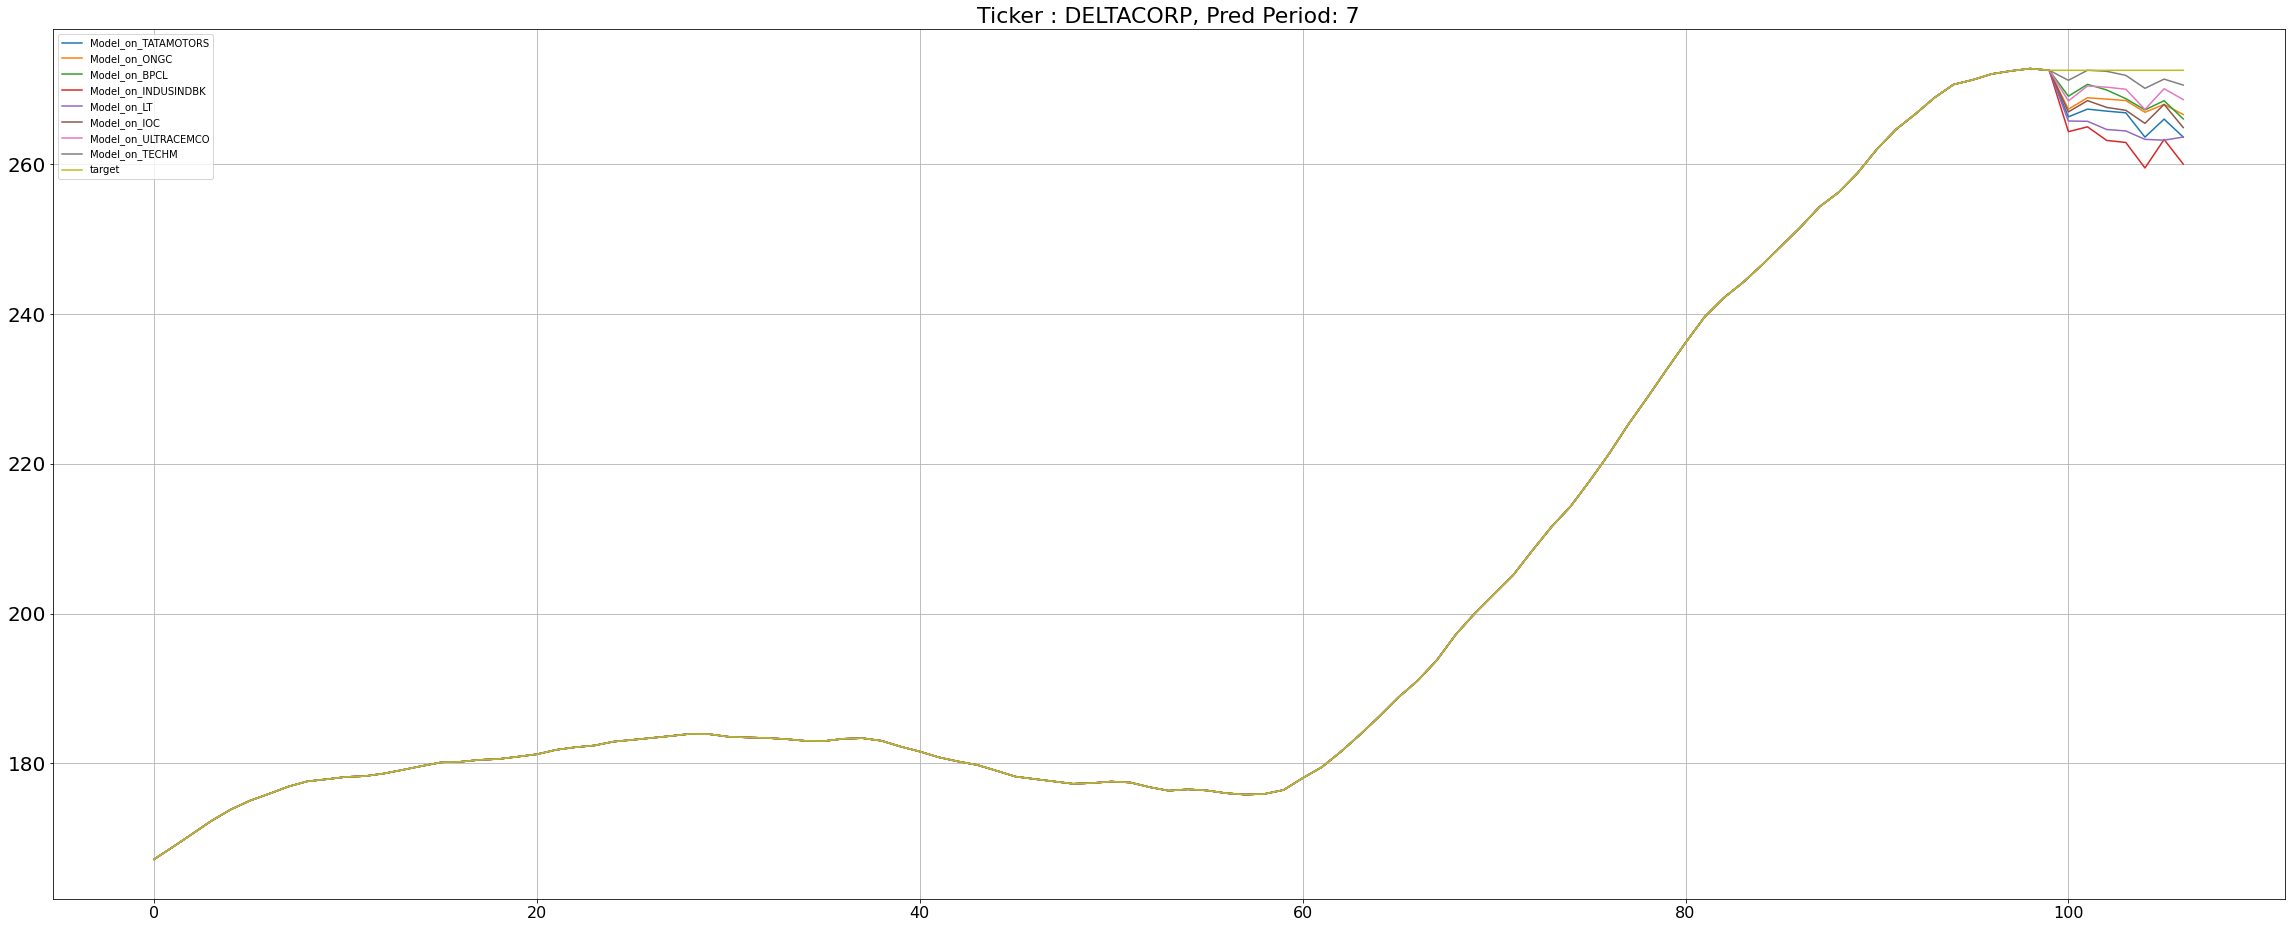

In [ ]:
n_model_chart_todays(ticker="DELTACORP",models=mod,t_model_names=all_tickers,path=path,days_cutoff = 1000,days_leave=3,pred_period=10,)

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(107,)
Losses tradeloss_2: [array(4.063786, dtype=float32), array(8.498005, dtype=float32), array(10.201033, dtype=float32), array(12.054697, dtype=float32), array(5.6797037, dtype=float32), array(4.365366, dtype=float32), array(9.009224, dtype=float32), array(75.46624, dtype=float32), array(15.997144, dtype=float32), array(5.094913, dtype=float32), array(8.03604, dtype=float32), array(11.449244, dtype=float32), array(4.8612266, dtype=float32), array(19.238958, dtype=float32), array(55.318962, dtype=float32), array(19.609673, dtype=float32), array(16.465017, dtype=float32), array(6.660678, dtype=float32), array(6.335345, dtype=float32)]

Mean loss: 15.70553970336914
Losses tradeloss_2: [array(6.4402423, dtype=float32), array(7.7976565, dtype=float32), array(7.384252, dtype=float32), array(10.570589, dtype=float32), array(9.077326, dtype=

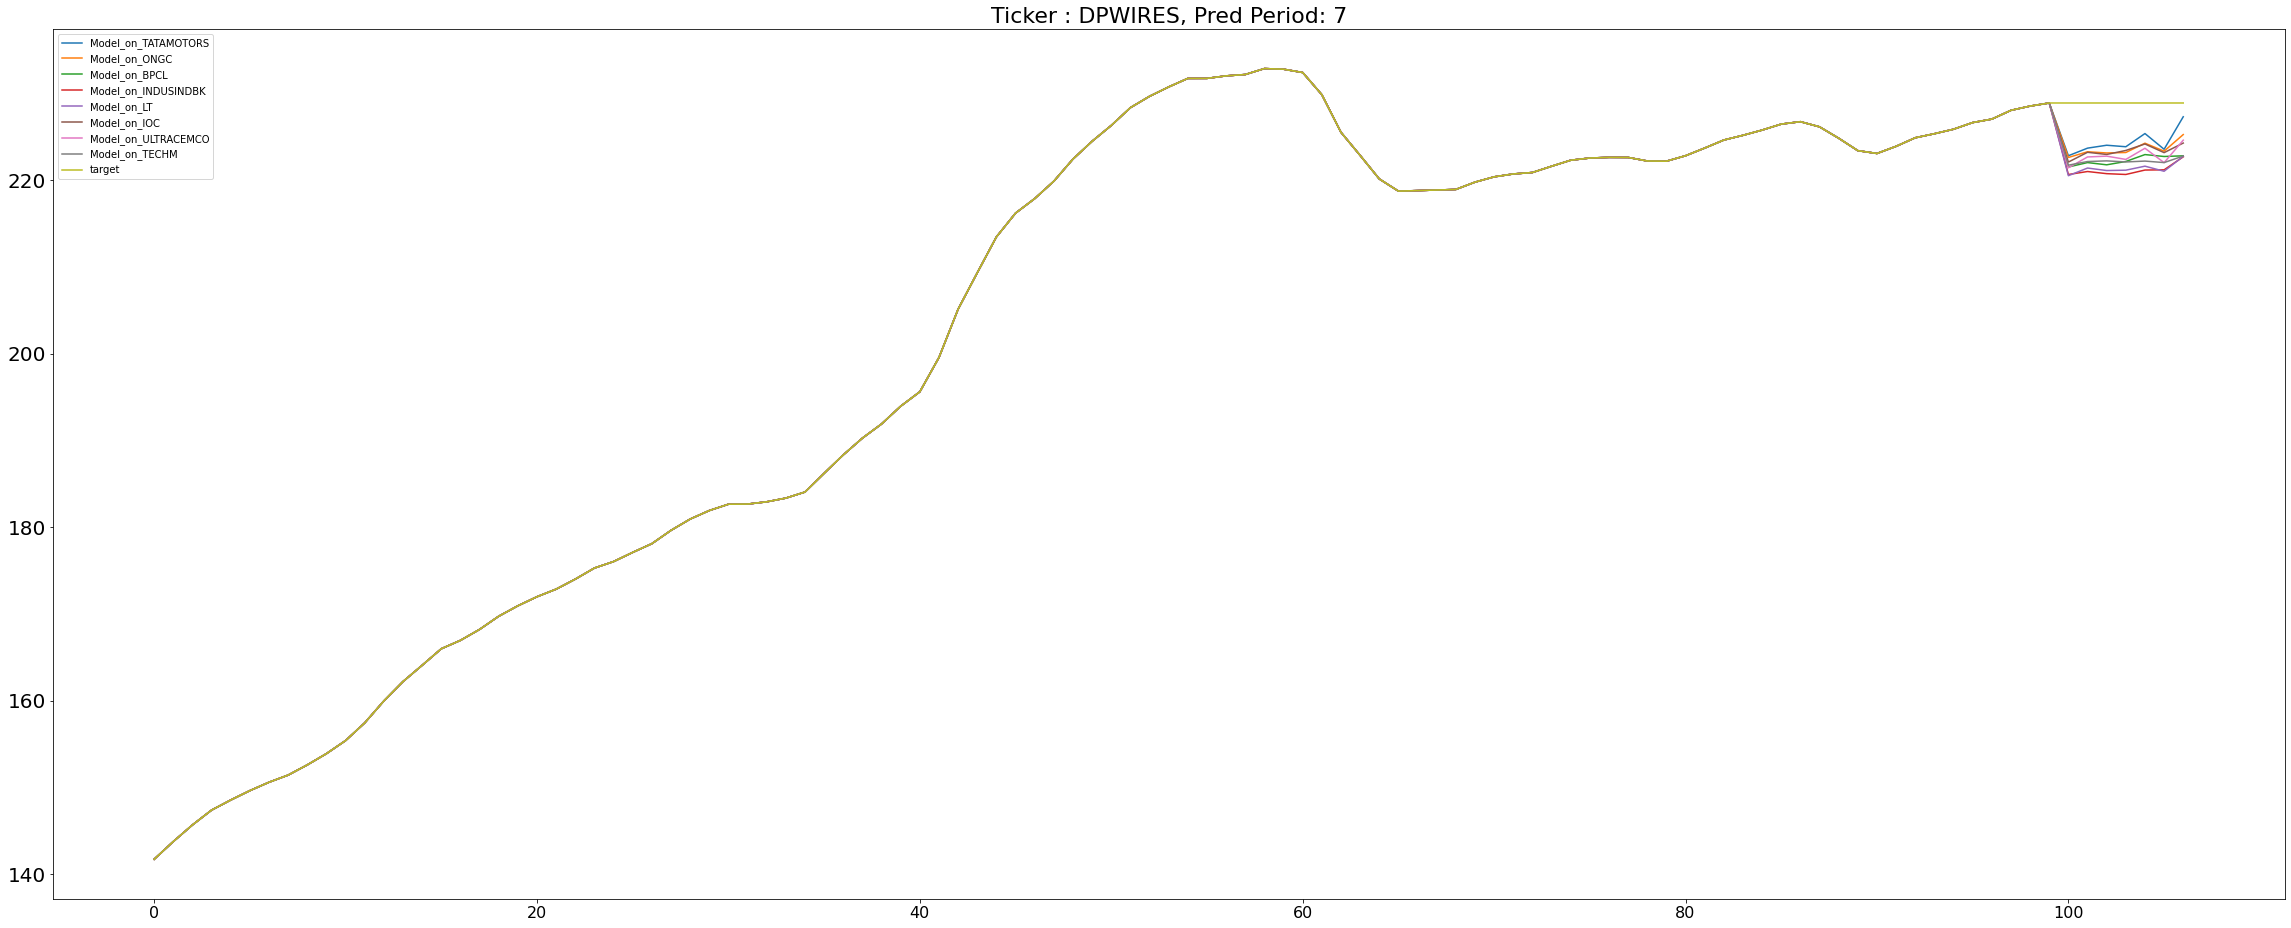

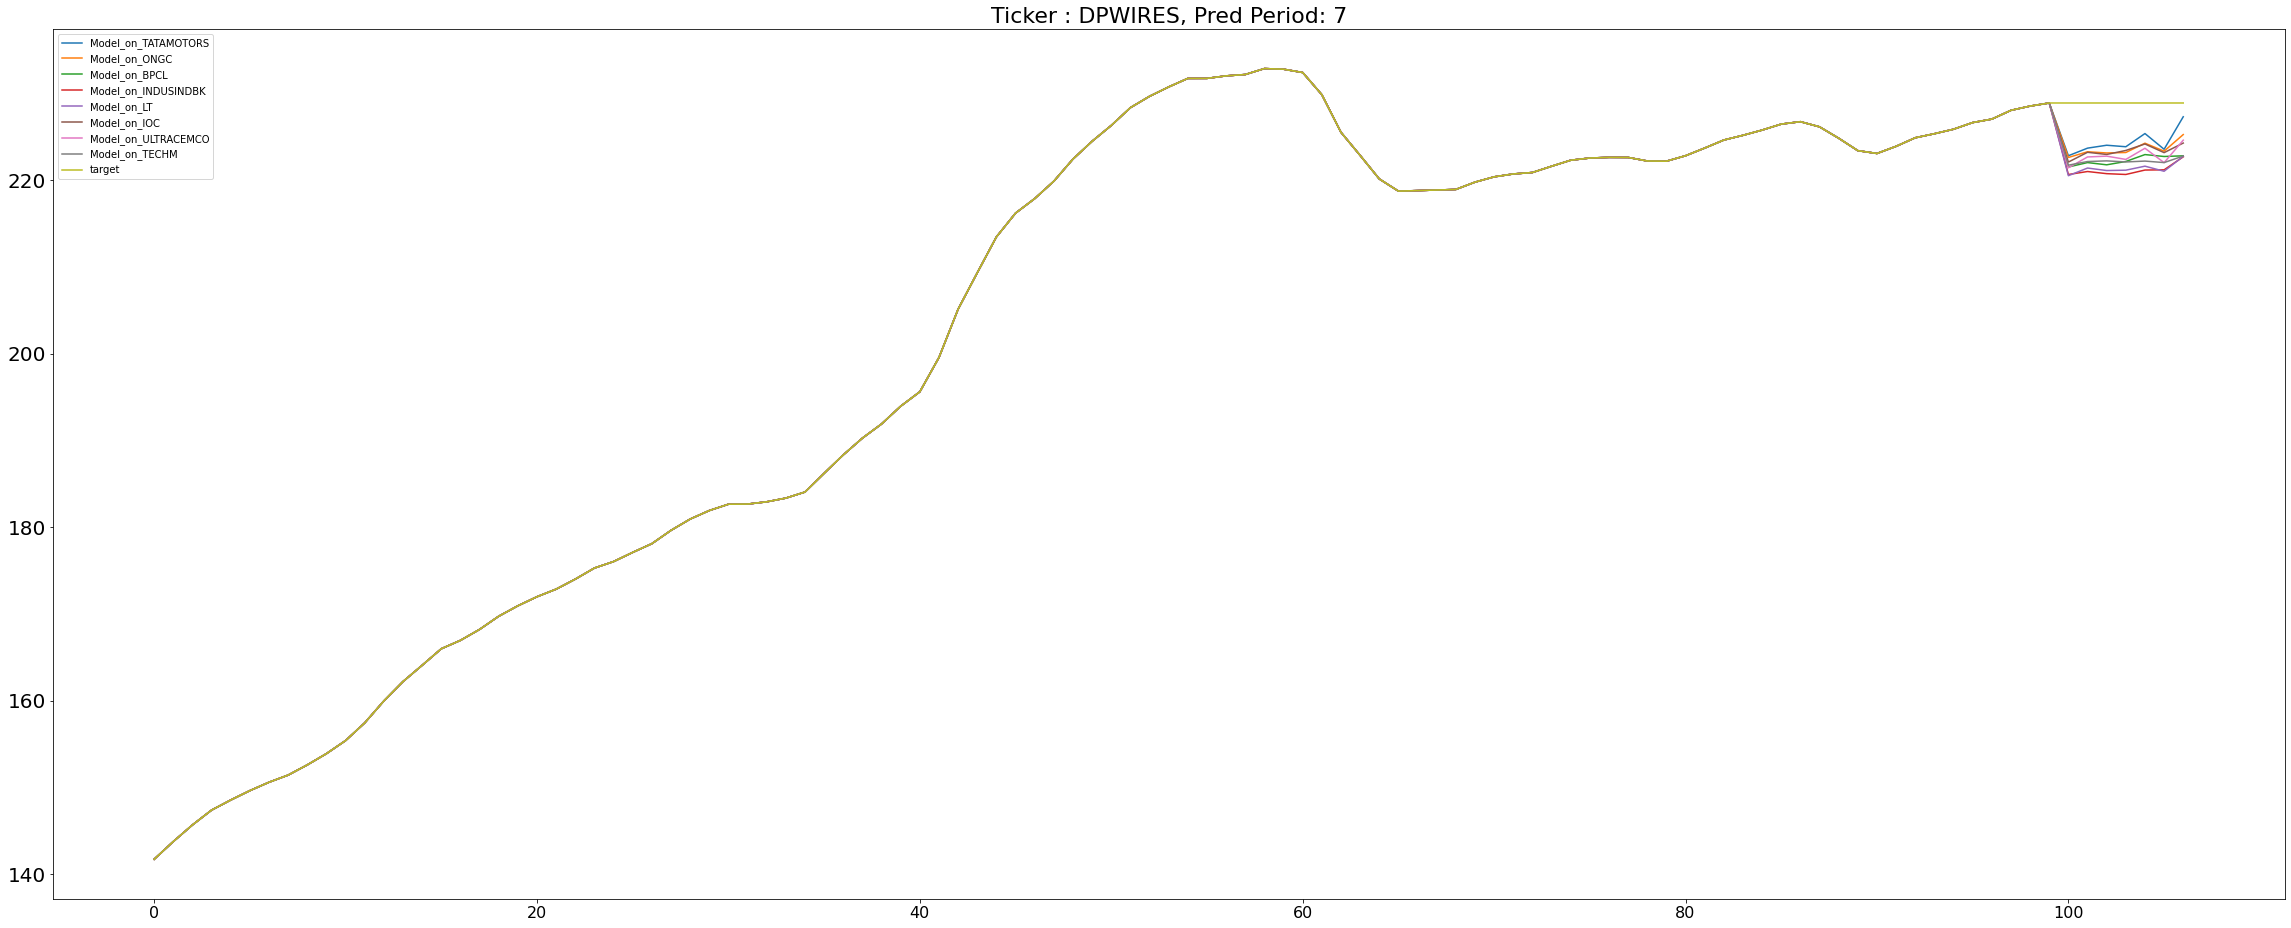

In [ ]:
n_model_chart_todays(ticker="DPWIRES",models=mod,t_model_names=all_tickers,path=path,days_cutoff = 1000,days_leave=3,pred_period=10,)